In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import sys
import os.path
import logging

import os
import tempfile

import time
import math
import pandas as pd
import tensorflow as tf

from enum import Enum

import datetime
from tensorflow import keras
from tensorflow.keras.callbacks import *

from google.cloud import bigquery
from google.api_core.exceptions import GoogleAPIError

from tensorflow.python.framework import ops
from tensorflow.python.framework import dtypes
import tensorflow_io as tf_io
from tensorflow_io.bigquery import BigQueryClient
from tensorflow_io.bigquery import BigQueryReadSession
from tensorflow.python.client import device_lib

from tensorflow.python.data.experimental.ops import interleave_ops
from tensorflow.python.data.ops import dataset_ops
from tensorflow.python.platform import gfile

import google.cloud.logging

import argparse

from tensorboardX import SummaryWriter

class BatchAccuracyAndLossSummaryCallback(tf.keras.callbacks.Callback):
  # TODO: make it dist. strat. compartible
  def __init__(self, log_dir, dataset_size):
    # Callback should only write summaries on the chief when in a Multi-Worker setting.
    self._chief_worker_only = True
    self.update_freq = 10 if dataset_size == DATASET_SIZE_TYPE.small else 500
    #file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
    #file_writer.set_as_default()
    self.writer = SummaryWriter(log_dir +'/scalar_metrics')

  def on_epoch_begin(self, epoch, logs=None):
    self.epoch = epoch
  def on_train_batch_end(self, batch, logs=None):
    if batch % self.update_freq == 0:
      if 'accuracy' in logs:
        self.writer.add_scalar('accuracy/train_epoch_{}'.format(self.epoch), logs['accuracy'], batch)
        self.writer.add_scalars('accuracy/combined', {'train_epoch_{}'.format(self.epoch):logs['accuracy']}, batch)
      if 'loss' in logs:
        self.writer.add_scalar('loss/train_epoch_{}'.format(self.epoch), logs['loss'], batch)
        self.writer.add_scalars('loss/combined', {'train_epoch_{}'.format(self.epoch):logs['loss']}, batch)
  def on_test_batch_end(self, batch, logs=None):
    if batch % self.update_freq // 10 == 0:
      if 'accuracy' in logs:
        self.writer.add_scalar('accuracy/test_epoch_{}'.format(self.epoch), logs['accuracy'], batch)
        self.writer.add_scalars('accuracy/combined', {'test_epoch_{}'.format(self.epoch):logs['accuracy']}, batch)
      if 'loss' in logs:
        self.writer.add_scalar('loss/test_epoch_{}'.format(self.epoch), logs['loss'], batch)
        self.writer.add_scalars('loss/combined', {'test_epoch_{}'.format(self.epoch):logs['loss']}, batch)
  def on_train_end(self, logs=None):
    self.writer.close()


class TrainTimeCallback(tf.keras.callbacks.Callback):
  def on_epoch_begin(self, epoch, logs=None):
    self.epoch_start_time = datetime.datetime.now()

  def on_epoch_end(self, epoch, logs=None):
    logging.info('\nepoch train time: (hh:mm:ss.ms) {}'.format(datetime.datetime.now() - self.epoch_start_time))
    if not self.params is None:
      if 'steps' in self.params:
        epoch_milliseconds = (datetime.datetime.now() - self.epoch_start_time).total_seconds() * 1000
        logging.info('{} ms/step'.format(epoch_milliseconds / self.params['steps']))
      if BATCH_SIZE is not None:
        logging.info('{} microseconds/example'.format(1000 * epoch_milliseconds  / self.params['steps'] / BATCH_SIZE))

  def on_train_begin(self, logs=None):
    self.start_training_time = datetime.datetime.now()

  def on_train_end(self, logs=None):
    logging.info('total train time: (hh:mm:ss.ms) {}'.format(datetime.datetime.now() - self.start_training_time))

LOCATION = 'us'
PROJECT_ID = "alekseyv-scalableai-dev" # TODO: replace with your project name
GOOGLE_APPLICATION_CREDENTIALS = "alekseyv-scalableai-dev-077efe757ef6.json" # TODO: replace with your key name
GOOGLE_APPLICATION_CREDENTIALS_GCS_BUCKET = 'gs://alekseyv-scalableai-dev-private-bucket/criteo' # TODO: replace with the path to the GCS bucket your project has access to

DATASET_ID = 'criteo_kaggle'

BATCH_SIZE = 128
EPOCHS = 5
EMBEDDINGS_MODE_TYPE_VALUES = 'none manual hashbucket vocabular'
EMBEDDINGS_MODE_TYPE = Enum('EMBEDDINGS_MODE_TYPE', 'none manual hashbucket vocabular')
EMBEDDINGS_MODE = EMBEDDINGS_MODE_TYPE.hashbucket

FULL_TRAIN_DATASET_SIZE = 36670642 # select count(1) from `alekseyv-scalableai-dev.criteo_kaggle.train`
SMALL_TRAIN_DATASET_SIZE = 366715  # select count(1) from `alekseyv-scalableai-dev.criteo_kaggle.train_small`

TRAIN_LOCATION_TYPE_VALUES = 'local cloud'
TRAIN_LOCATION_TYPE = Enum('TRAIN_LOCATION_TYPE', TRAIN_LOCATION_TYPE_VALUES)
TRAIN_LOCATION = TRAIN_LOCATION_TYPE.local

# https://www.tensorflow.org/guide/distributed_training
DISTRIBUTION_STRATEGY_TYPE = None
DISTRIBUTION_STRATEGY_TYPE_VALUES = 'tf.distribute.MirroredStrategy tf.distribute.experimental.ParameterServerStrategy ' \
  'tf.distribute.experimental.MultiWorkerMirroredStrategy tf.distribute.experimental.CentralStorageStrategy ' \
  'tf.distribute.experimental.TPUStrategy tf.distribute.OneDeviceStrategy'
TRAINING_FUNCTION_VALUES = 'train_keras_sequential train_keras_functional train_keras_functional_wide_and_deep ' \
  'train_keras_to_estimator_functional train_keras_to_estimator_sequential train_estimator train_estimator_wide_and_deep ' \
  'train_keras_functional_no_feature_layer train_custom_loop_keras_sequential train_custom_loop_keras_model_functional_no_feature_layer ' \
  'train_keras_sequential_wide_and_deep'

DATASET_SIZE_TYPE = Enum('DATASET_SIZE_TYPE', 'full small')
DATASET_SIZE = DATASET_SIZE_TYPE.small

DATASET_SOURCE_TYPE = Enum('DATASET_SOURCE_TYPE', 'bq gcs')
DATASET_SOURCE = DATASET_SOURCE_TYPE.bq

CSV_SCHEMA = [
      bigquery.SchemaField("label", "INTEGER", mode='REQUIRED'),
      bigquery.SchemaField("int1", "INTEGER"),
      bigquery.SchemaField("int2", "INTEGER"),
      bigquery.SchemaField("int3", "INTEGER"),
      bigquery.SchemaField("int4", "INTEGER"),
      bigquery.SchemaField("int5", "INTEGER"),
      bigquery.SchemaField("int6", "INTEGER"),
      bigquery.SchemaField("int7", "INTEGER"),
      bigquery.SchemaField("int8", "INTEGER"),
      bigquery.SchemaField("int9", "INTEGER"),
      bigquery.SchemaField("int10", "INTEGER"),
      bigquery.SchemaField("int11", "INTEGER"),
      bigquery.SchemaField("int12", "INTEGER"),
      bigquery.SchemaField("int13", "INTEGER"),
      bigquery.SchemaField("cat1", "STRING"),
      bigquery.SchemaField("cat2", "STRING"),
      bigquery.SchemaField("cat3", "STRING"),
      bigquery.SchemaField("cat4", "STRING"),
      bigquery.SchemaField("cat5", "STRING"),
      bigquery.SchemaField("cat6", "STRING"),
      bigquery.SchemaField("cat7", "STRING"),
      bigquery.SchemaField("cat8", "STRING"),
      bigquery.SchemaField("cat9", "STRING"),
      bigquery.SchemaField("cat10", "STRING"),
      bigquery.SchemaField("cat11", "STRING"),
      bigquery.SchemaField("cat12", "STRING"),
      bigquery.SchemaField("cat13", "STRING"),
      bigquery.SchemaField("cat14", "STRING"),
      bigquery.SchemaField("cat15", "STRING"),
      bigquery.SchemaField("cat16", "STRING"),
      bigquery.SchemaField("cat17", "STRING"),
      bigquery.SchemaField("cat18", "STRING"),
      bigquery.SchemaField("cat19", "STRING"),
      bigquery.SchemaField("cat20", "STRING"),
      bigquery.SchemaField("cat21", "STRING"),
      bigquery.SchemaField("cat22", "STRING"),
      bigquery.SchemaField("cat23", "STRING"),
      bigquery.SchemaField("cat24", "STRING"),
      bigquery.SchemaField("cat25", "STRING"),
      bigquery.SchemaField("cat26", "STRING")
  ]

# See https://docs.google.com/spreadsheets/d/1s_QCP4dyO9L9QXVQu0TKrIi767kMwlr8SsfAX5UCNrw/edit#gid=118220263
KEY_CROSSES = [
  ['cat13','cat18'],
  ['cat11', 'cat18'],
  ['cat11', 'cat15'],
  ['cat2', 'cat8'],
  ['cat7', 'cat15'],
  ['cat13', 'cat15'],
  ['cat1', 'cat2'],
  ['cat13', 'cat19'],
  ['cat2', 'cat13'],
  ['cat7', 'cat18'],
  ['cat1', 'cat13'],
  ['cat2', 'cat5'],
  ['cat2', 'cat11'],
  ['cat11', 'cat19'],
  ['cat1', 'cat11'],
  ['cat8', 'cat13']
]

def get_mean_and_std_dicts():
  table_name = 'days' if DATASET_SIZE == DATASET_SIZE_TYPE.full else 'small'
  client = bigquery.Client(project=PROJECT_ID)
  query = """
    select
    AVG(int1) as avg_int1, STDDEV(int1) as std_int1,
    AVG(int2) as avg_int2, STDDEV(int2) as std_int2,
    AVG(int3) as avg_int3, STDDEV(int3) as std_int3,
    AVG(int4) as avg_int4, STDDEV(int4) as std_int4,
    AVG(int5) as avg_int5, STDDEV(int5) as std_int5,
    AVG(int6) as avg_int6, STDDEV(int6) as std_int6,
    AVG(int7) as avg_int7, STDDEV(int7) as std_int7,
    AVG(int8) as avg_int8, STDDEV(int8) as std_int8,
    AVG(int9) as avg_int9, STDDEV(int9) as std_int9,
    AVG(int10) as avg_int10, STDDEV(int10) as std_int10,
    AVG(int11) as avg_int11, STDDEV(int11) as std_int11,
    AVG(int12) as avg_int12, STDDEV(int12) as std_int12,
    AVG(int13) as avg_int13, STDDEV(int13) as std_int13
    from `alekseyv-scalableai-dev.criteo_kaggle.{table_name}`
  """.format(table_name = table_name)
  query_job = client.query(
      query,
      location=LOCATION,
  )  # API request - starts the query

  df = query_job.to_dataframe()

  mean_dict = dict((field[0].replace('avg_', ''), df[field[0]][0]) for field in df.items() if field[0].startswith('avg'))
  std_dict = dict((field[0].replace('std_', ''), df[field[0]][0]) for field in df.items() if field[0].startswith('std'))
  return (mean_dict, std_dict)

def get_vocabulary_size_dict():
  table_name = 'days' if DATASET_SIZE == DATASET_SIZE_TYPE.full else 'small'
  client = bigquery.Client(project=PROJECT_ID)
  query = """
    SELECT
    COUNT(DISTINCT cat1) as cat1,
    COUNT(DISTINCT cat2) as cat2,
    COUNT(DISTINCT cat3) as cat3,
    COUNT(DISTINCT cat4) as cat4,
    COUNT(DISTINCT cat5) as cat5,
    COUNT(DISTINCT cat6) as cat6,
    COUNT(DISTINCT cat7) as cat7,
    COUNT(DISTINCT cat8) as cat8,
    COUNT(DISTINCT cat9) as cat9,
    COUNT(DISTINCT cat10) as cat10,
    COUNT(DISTINCT cat11) as cat11,
    COUNT(DISTINCT cat12) as cat12,
    COUNT(DISTINCT cat13) as cat13,
    COUNT(DISTINCT cat14) as cat14,
    COUNT(DISTINCT cat15) as cat15,
    COUNT(DISTINCT cat16) as cat16,
    COUNT(DISTINCT cat17) as cat17,
    COUNT(DISTINCT cat18) as cat18,
    COUNT(DISTINCT cat19) as cat19,
    COUNT(DISTINCT cat20) as cat20,
    COUNT(DISTINCT cat21) as cat21,
    COUNT(DISTINCT cat22) as cat22,
    COUNT(DISTINCT cat23) as cat23,
    COUNT(DISTINCT cat24) as cat24,
    COUNT(DISTINCT cat25) as cat25,
    COUNT(DISTINCT cat26) as cat26
    FROM
      `alekseyv-scalableai-dev.criteo_kaggle.{table_name}`
  """.format(table_name = table_name)
  query_job = client.query(
      query,
      location=LOCATION,
  )  # API request - starts the query

  df = query_job.to_dataframe()
  dictionary = dict((field[0], df[field[0]][0]) for field in df.items())
  return dictionary

def get_corpus_dict():
  table_name = 'days' if DATASET_SIZE == DATASET_SIZE_TYPE.full else 'small'
  client = bigquery.Client(project=PROJECT_ID)
  query = """
    select
    cat_name,
    cat_value,
    cat_index
    from `alekseyv-scalableai-dev.criteo_kaggle.{table_name}_corpus`
  """.format(table_name = table_name)
  query_job = client.query(
      query,
      location="US",
  )  # API request - starts the query

  df = query_job.to_dataframe()
  corpus = dict()
  for _, row in df.iterrows():
    cat_name = row[0]
    cat_value = row[1]
    cat_index = row[2]
    if not cat_name in corpus:
      corpus[cat_name] = dict()
    if cat_value is None:
      cat_value = ''
    corpus[cat_name][cat_value] = cat_index
  return corpus

def corpus_to_lookuptable(corpus):
  lookup_dict = dict()
  for key, value in corpus.items():
    initializer = tf.lookup.KeyValueTensorInitializer(
      list(value.keys()),
      list(value.values()),
      key_dtype=tf.string,
      value_dtype=tf.int64)
    # cat_index in corpus starts with 1, reserving 0 for out of vocabulary values
    lookup_table = tf.lookup.StaticHashTable(initializer, 0)
    lookup_dict[key] = lookup_table
  return lookup_dict

def get_corpus():
  if EMBEDDINGS_MODE == EMBEDDINGS_MODE_TYPE.manual or EMBEDDINGS_MODE == EMBEDDINGS_MODE_TYPE.vocabular:
    return corpus_to_lookuptable(get_corpus_dict())
  else:
    return dict()

# @tf.function is not really necessary here since function is used in tf.data pipeline
# Use print(tf.autograph.to_code(transform_row.python_function)) to see code generated by AutoGraph
@tf.function
def transform_row(row_dict, mean_dict, std_dict, corpus):
  dict_without_label = dict(row_dict)
  label = dict_without_label.pop('label')
  for field in CSV_SCHEMA:
    if (field.name.startswith('int')):
        # use normalized mean value if data is missing (value will be 0)
        value = float(dict_without_label[field.name])
        dict_without_label[field.name] = (value - mean_dict[field.name]) / std_dict[field.name]
    elif field.name.startswith('cat'):
      if EMBEDDINGS_MODE == EMBEDDINGS_MODE_TYPE.none:
        dict_without_label.pop(field.name)
      elif EMBEDDINGS_MODE == EMBEDDINGS_MODE_TYPE.manual:
        cat = dict_without_label[field.name]
        if cat is None:
          cat = ''
        cat_index = corpus[field.name].lookup(cat)
        if cat_index is None:
          tf.print('not found for {}'.format(field.name))
          cat_index = tf.constant(-1)
        dict_without_label[field.name] = cat_index
  return (dict_without_label, label)

def read_bigquery(table_name):
  if DATASET_SIZE == DATASET_SIZE_TYPE.small:
    table_name += '_small'

  (mean_dict, std_dict) = get_mean_and_std_dicts()
  corpus = get_corpus()
  requested_streams_count = 10
  tensorflow_io_bigquery_client = BigQueryClient()
  read_session = tensorflow_io_bigquery_client.read_session(
      "projects/" + PROJECT_ID,
      PROJECT_ID, table_name, DATASET_ID,
      list(field.name for field in CSV_SCHEMA),
      list(dtypes.int64 if field.field_type == 'INTEGER'
           else dtypes.string for field in CSV_SCHEMA),
      requested_streams=requested_streams_count)

  # manually sharding output instaead of using return read_session.parallel_read_rows()
  streams = read_session.get_streams()
  # streams_count = len(streams) # does not work for Estimator
  streams_count = tf.size(streams)
  streams_count64 = tf.cast(streams_count, dtype=tf.int64)
  streams_ds = dataset_ops.Dataset.from_tensor_slices(streams).shuffle(buffer_size=streams_count64)
  dataset = streams_ds.interleave(
            read_session.read_rows,
            cycle_length=streams_count64,
            num_parallel_calls=streams_count64)

  transform_row_function = lambda row: transform_row(row, mean_dict, std_dict, corpus)

  transformed_ds = dataset\
    .batch(BATCH_SIZE) \
    .shuffle(50) \
    .map (transform_row_function, num_parallel_calls=streams_count) \
    .prefetch(50)

  # TODO: enable once tf.data.experimental.AutoShardPolicy.OFF is available
  # Interleave dataset is not shardable, turning off sharding
  # See https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras#dataset_sharding_and_batch_size
  # Instead we are shuffling data.
  # options = tf.data.Options()
  #  options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
  # return transformed_ds.with_options(options)
  return transformed_ds

def transofrom_row_gcs(row_tuple, mean_dict, std_dict, corpus):
    row_dict = dict(zip(list(field.name for field in CSV_SCHEMA) + ['row_hash'], list(row_tuple)))
    row_dict.pop('row_hash')
    return transform_row(row_dict, mean_dict, std_dict, corpus)


def _get_file_names(file_pattern):
  if isinstance(file_pattern, list):
    if not file_pattern:
      raise ValueError("File pattern is empty.")
    file_names = []
    for entry in file_pattern:
      file_names.extend(gfile.Glob(entry))
  else:
    file_names = list(gfile.Glob(file_pattern))

  if not file_names:
    raise ValueError("No files match %s." % file_pattern)
  return file_names

def read_gcs(table_name):
  if DATASET_SIZE == DATASET_SIZE_TYPE.small:
    table_name += '_small'
  else:
    table_name += '_full'

  gcs_filename_glob = 'gs://alekseyv-scalableai-dev-public-bucket/criteo_kaggle_from_bq/{}*'.format(table_name)
  file_names = _get_file_names(gcs_filename_glob)
  num_parallel_calls = max(10, len(file_names))
  file_names_ds = dataset_ops.Dataset.from_tensor_slices(file_names).shuffle(buffer_size=20)
  record_defaults = list(tf.int32 if field.name == 'label' else tf.constant(0, dtype=tf.int32) if field.name.startswith('int') else tf.constant('', dtype=tf.string) for field in CSV_SCHEMA) + [tf.string]
  dataset = file_names_ds.interleave(
          lambda file_name: tf.data.experimental.CsvDataset(file_name, record_defaults, field_delim='\t', header=False),
          cycle_length=num_parallel_calls,
          num_parallel_calls=num_parallel_calls)

  corpus = get_corpus()
  (mean_dict, std_dict) = get_mean_and_std_dicts()
  transofrom_row_gcs_function = lambda *row_tuple: transofrom_row_gcs(row_tuple, mean_dict, std_dict, corpus)

  transformed_ds = dataset\
    .batch(BATCH_SIZE) \
    .shuffle(50) \
    .map (transofrom_row_gcs_function, num_parallel_calls=num_parallel_calls) \
    .prefetch(50)
  return transformed_ds

def get_dataset(table_name):
  global DATASET_SOURCE
  return read_gcs(table_name) if DATASET_SOURCE == DATASET_SOURCE_TYPE.gcs else read_bigquery(table_name)

def get_max_steps():
  dataset_size = FULL_TRAIN_DATASET_SIZE if DATASET_SIZE == DATASET_SIZE_TYPE.full else SMALL_TRAIN_DATASET_SIZE
  return EPOCHS * dataset_size // BATCH_SIZE

def create_categorical_feature_column_with_hash_bucket(corpus_dict, key):
  corpus_size = len(corpus_dict[key])
  hash_bucket_size = min(corpus_size, 100000)
  categorical_feature_column = tf.feature_column.categorical_column_with_hash_bucket(
    key,
    hash_bucket_size,
    dtype=tf.dtypes.string
  )
  logging.info('categorical column %s hash_bucket_size %d', key, hash_bucket_size)
  return categorical_feature_column

def create_categorical_feature_column_with_vocabulary_list(corpus_dict, key):
  corpus_size = len(corpus_dict[key])
  categorical_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(
    key,
    list(corpus_dict[key].keys()),
    dtype=tf.dtypes.string,
    num_oov_buckets=corpus_size
  )
  logging.info('categorical column with vocabular %s corpus_size %d', key, corpus_size)

  return categorical_feature_column

def create_embedding(corpus_dict, key, categorical_feature_column):
  corpus_size = len(corpus_dict[key])
  if corpus_size < 10:
    logging.info('categorical column %s corpus_size %d - creating indicator column', key, corpus_size)
    return tf.feature_column.indicator_column(categorical_feature_column)

  embedding_dimension = int(min(50, math.floor(6 * corpus_size**0.25)))
  embedding_feature_column = tf.feature_column.embedding_column(
      categorical_feature_column,
      embedding_dimension)
  return embedding_feature_column

def create_linear_feature_columns():
  return list(tf.feature_column.numeric_column(field.name, dtype=tf.dtypes.float32)  for field in CSV_SCHEMA if field.field_type == 'INTEGER' and field.name != 'label')

def create_categorical_embeddings_feature_columns(corpus_dict):
  if EMBEDDINGS_MODE == EMBEDDINGS_MODE_TYPE.none:
    return []
  elif EMBEDDINGS_MODE == EMBEDDINGS_MODE_TYPE.hashbucket:
    return list(create_embedding(
      corpus_dict,
      key,
      create_categorical_feature_column_with_hash_bucket(corpus_dict, key))
        for key, _ in corpus_dict.items())
  elif EMBEDDINGS_MODE == EMBEDDINGS_MODE_TYPE.vocabular:
    return list(create_embedding(
      corpus_dict,
      key,
      create_categorical_feature_column_with_vocabulary_list(corpus_dict, key))
        for key, _ in corpus_dict.items())
  else:
    raise ValueError('invalid EMBEDDINGS_MODE: {}'.format(EMBEDDINGS_MODE))

def create_feature_columns():
  corpus_dict = get_corpus_dict()
  feature_columns = []
  feature_columns.extend(create_linear_feature_columns())
  feature_columns.extend(create_categorical_embeddings_feature_columns(corpus_dict))
  return feature_columns

def create_input_layer():
    numeric_feature_columns = create_linear_feature_columns()
    numerical_input_layers = {
       feature_column.name: tf.keras.layers.Input(name=feature_column.name, shape=(1,), dtype=tf.float32)
       for feature_column in numeric_feature_columns
    }
    categorical_feature_columns = create_categorical_embeddings_feature_columns()
    categorical_input_layers = {
       feature_column.categorical_column.name: tf.keras.layers.Input(name=feature_column.categorical_column.name, shape=(), dtype=tf.string)
       for feature_column in categorical_feature_columns
    }
    input_layers = numerical_input_layers.copy()
    input_layers.update(categorical_input_layers)

    return (input_layers, numeric_feature_columns + categorical_feature_columns)

def create_embedding_from_input(corpus_dict, name, input_layer):
  size = len(corpus_dict[name]) + 2
  dimension =  int(min(50, math.floor(6 * size**0.25)))
  logging.info('embedding name:{} size:{} dim:{}'.format(name, size, dimension))
  embedding = tf.keras.layers.Embedding(size, dimension, name = name + '_embedding', input_length=1)(input_layer)
  return embedding

def create_keras_model_functional():
    (feature_layer_inputs, feature_columns) = create_input_layer()
    feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
    feature_layer_outputs = feature_layer(feature_layer_inputs)
    x = tf.keras.layers.Dense(2560, activation=tf.nn.relu)(feature_layer_outputs)
    x = tf.keras.layers.Dense(1024, activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dense(256, activation=tf.nn.relu)(x)
    outputs = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)
    inputs=[v for v in feature_layer_inputs.values()]
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile Keras model
    model.compile(
      # cannot use Adagrad with mirroredstartegy https://github.com/tensorflow/tensorflow/issues/19551
      optimizer=tf.optimizers.SGD(learning_rate=0.05),
      #optimizer=tf.optimizers.Adam(),
      #optimizer=tf.optimizers.Adagrad(),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=['accuracy'])
    logging.info("model: " + str(model.summary()))
    return model

def create_keras_model_functional_no_feature_layer():
  corpus_dict = get_corpus_dict()
  categorical_input_with_names = list((field.name, tf.keras.layers.Input(shape=[1], name = field.name, dtype=tf.int32))
    for field in CSV_SCHEMA if field.field_type == 'STRING' and field.name != 'label')
  categorical_inputs = list(input_layer
    for (name, input_layer) in categorical_input_with_names)
  categorical_embeddings = list(create_embedding_from_input(corpus_dict, name, input_layer)
    for (name, input_layer) in categorical_input_with_names)

  numerical_inputs = list(tf.keras.layers.Input(shape=[1], name = field.name, dtype=tf.float32)
    for field in CSV_SCHEMA if field.field_type == 'INTEGER' and field.name != 'label')

  categorical_combined = tf.keras.layers.concatenate(categorical_embeddings)
  x = tf.keras.layers.Flatten()(categorical_combined)
  x = tf.keras.layers.concatenate([x] + numerical_inputs)
  x = tf.keras.layers.Dense(2560, activation=tf.nn.relu)(x)
  x = tf.keras.layers.Dense(1024, activation=tf.nn.relu)(x)
  x = tf.keras.layers.Dense(256, activation=tf.nn.relu)(x)

  outputs = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)
  model = tf.keras.Model(inputs=categorical_inputs + numerical_inputs, outputs=outputs)

  # Compile Keras model
  model.compile(
    # cannot use Adagrad with mirroredstartegy https://github.com/tensorflow/tensorflow/issues/19551
    optimizer=tf.optimizers.SGD(learning_rate=0.05),
    #optimizer=tf.optimizers.Adam(),
    #optimizer=tf.optimizers.Adagrad(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])
  logging.info("model: " + str(model.summary()))

  return model

def create_keras_model_functional_wide_and_deep_dontuse():
    (feature_layer_inputs, feature_columns) = create_input_layer()
    categorical_feature_columns=create_categorical_embeddings_feature_columns()

    wide = tf.keras.layers.DenseFeatures(categorical_feature_columns)(feature_layer_inputs)

    deep = tf.keras.layers.DenseFeatures(feature_columns)(feature_layer_inputs)
    deep = tf.keras.layers.Dense(2560, activation=tf.nn.relu)(deep)
    deep = tf.keras.layers.Dense(1024, activation=tf.nn.relu)(deep)
    deep = tf.keras.layers.Dense(256, activation=tf.nn.relu)(deep)

    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(
      tf.keras.layers.concatenate([deep, wide]))

    outputs = tf.squeeze(outputs, -1)
    inputs=[v for v in feature_layer_inputs.values()]
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # Compile Keras model
    model.compile(
      # cannot use Adagrad with mirroredstartegy https://github.com/tensorflow/tensorflow/issues/19551
      #optimizer=tf.optimizers.Adagrad(learning_rate=0.05),
      optimizer=tf.optimizers.SGD(learning_rate=0.05),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=['accuracy'])
    logging.info("model: " + str(model.summary()))
    return model

def create_keras_model_sequential_wide_and_deep():
    if EMBEDDINGS_MODE == EMBEDDINGS_MODE_TYPE.none:
      raise ValueError('embeddings are required for wide and deep model')

    linear_feature_columns = create_linear_feature_columns()
    corpus_dict = get_corpus_dict()
    categorical_feature_columns_and_embeddings = create_categorical_embeddings_feature_columns(corpus_dict)
    categorical_feature_columns = list(tf.feature_column.indicator_column(embedding.categorical_column) for embedding in categorical_feature_columns_and_embeddings)
    embeddings = list(embedding for embedding in categorical_feature_columns_and_embeddings)

    crossed_columns = list(tf.feature_column.indicator_column(tf.feature_column.crossed_column(
      keys,
      min(max(len(corpus_dict[keys[0]]), len(corpus_dict[keys[1]])), 100000))) for keys in KEY_CROSSES)

    deep_model_feature_columns = embeddings + linear_feature_columns
    dense_feature_layer = tf.keras.layers.DenseFeatures(deep_model_feature_columns)
    Dense = tf.keras.layers.Dense
    dense_model = tf.keras.Sequential(
    [
        dense_feature_layer,
        Dense(2560, activation=tf.nn.relu),
        Dense(1024, activation=tf.nn.relu),
        Dense(256, activation=tf.nn.relu),
        Dense(1, activation=tf.nn.sigmoid)
    ])

    wide_model_feature_columns = categorical_feature_columns + crossed_columns
    # no sparse alternative, see https://github.com/tensorflow/community/pull/188/
    # https://cs/piper///depot/google3/learning/tfx/users/tfx/examples/tfx_keras_widedeep/models/premade_widedeep/model.py;rcl=291050847;l=100
    sparse_feature_layer = tf.keras.layers.DenseFeatures(wide_model_feature_columns)

    linear_model = tf.keras.Sequential(
    [
      sparse_feature_layer,
      Dense(1, activation=tf.nn.sigmoid)
    ])

    wide_deep_model = tf.keras.experimental.WideDeepModel(linear_model, dense_model)
    #wide_deep_model(deep_model_feature_columns) # todo change
    linear_opt = tf.keras.optimizers.RMSprop()
    dnn_opt = tf.keras.optimizers.Adam()

    wide_deep_model.compile(
        optimizer=[linear_opt, dnn_opt],
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy'])

    return wide_deep_model

def create_keras_model_sequential():
  feature_columns = create_feature_columns()

  feature_layer = tf.keras.layers.DenseFeatures(feature_columns, name="feature_layer")
  Dense = tf.keras.layers.Dense
  model = tf.keras.Sequential(
  [
      feature_layer,
      Dense(2560, activation=tf.nn.relu),
      Dense(1024, activation=tf.nn.relu),
      Dense(256, activation=tf.nn.relu),
      Dense(1, activation=tf.nn.sigmoid)
  ])

  logging.info('compiling sequential keras model')
  # Compile Keras model
  model.compile(
      # cannot use Adagrad with mirroredstartegy https://github.com/tensorflow/tensorflow/issues/19551
      #optimizer=tf.optimizers.Adagrad(learning_rate=0.05),
      optimizer=tf.optimizers.SGD(learning_rate=0.05),
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=['accuracy'])
  return model

def train_and_evaluate_keras_model(model, model_dir):
  dataset_size = FULL_TRAIN_DATASET_SIZE if DATASET_SIZE == DATASET_SIZE_TYPE.full else SMALL_TRAIN_DATASET_SIZE
  logging.info('training datset size: {}'.format(dataset_size))
  training_ds = get_dataset('train')

  #log_dir= os.path.join(model_dir, "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  log_dir= os.path.join(model_dir, "logs")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    embeddings_freq=1,
    profile_batch=min(EPOCHS, 2))

  checkpoints_dir= os.path.join(model_dir, "checkpoints")
  # crashing https://github.com/tensorflow/tensorflow/issues/27688
  if not os.path.exists(checkpoints_dir):
      os.makedirs(checkpoints_dir)

  callbacks=[]
  train_time_callback = TrainTimeCallback()
  batch_summary_callback = BatchAccuracyAndLossSummaryCallback(log_dir, DATASET_SIZE)

  if DISTRIBUTION_STRATEGY_TYPE == 'tf.distribute.experimental.TPUStrategy':
    # epoch and accuracy constants are not supported when training on TPU.
    checkpoints_file_path = checkpoints_dir + "/epochs_tpu.hdf5"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoints_file_path, verbose=1, mode='max')
    callbacks=[tensorboard_callback, checkpoint_callback, train_time_callback]
  else:
    if EMBEDDINGS_MODE == EMBEDDINGS_MODE_TYPE.manual or DISTRIBUTION_STRATEGY_TYPE == 'tf.distribute.experimental.MultiWorkerMirroredStrategy':
      # accuracy fails for adagrad
      # for some reason accuracy is not available for EMBEDDINGS_MODE_TYPE.manual
      # for some reason accuracy is not available for MultiWorkerMirroredStrategy
      checkpoints_file_path = checkpoints_dir + "/epochs:{epoch:03d}.hdf5"
    else:
      checkpoints_file_path = checkpoints_dir + "/epochs:{epoch:03d}-accuracy:{accuracy:.3f}.hdf5"
    checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoints_file_path, verbose=1, mode='max')
    callbacks=[tensorboard_callback, checkpoint_callback, batch_summary_callback, train_time_callback]
    #callbacks=[tensorboard_callback, checkpoint_callback, train_time_callback]

  verbosity = 1 if TRAIN_LOCATION == TRAIN_LOCATION_TYPE.local else 2
  logging.info('training keras model')
  model.fit(training_ds, epochs=EPOCHS, verbose=verbosity, callbacks=callbacks)
  eval_ds = get_dataset('test')
  logging.info("done training keras model, evaluating model")
  loss, accuracy = model.evaluate(eval_ds, verbose=verbosity, callbacks=[tensorboard_callback, batch_summary_callback])
  logging.info("Eval - Loss: {}, Accuracy: {}".format(loss, accuracy))
  logging.info(model.summary())
  logging.info("done evaluating keras model")

def train_keras_model_to_estimator(strategy, model, model_dir):
    logging.info('training for {} steps'.format(get_max_steps()))
    config = tf.estimator.RunConfig(
            train_distribute=strategy,
            eval_distribute=strategy)
    keras_estimator = tf.keras.estimator.model_to_estimator(
        keras_model=model, model_dir=model_dir, config=config)
    # Need to specify both max_steps and epochs. Each worker will go through epoch separately.
    # see https://www.tensorflow.org/api_docs/python/tf/estimator/train_and_evaluate?version=stable
    tf.estimator.train_and_evaluate(
        keras_estimator,
        train_spec=tf.estimator.TrainSpec(input_fn=lambda: get_dataset('train').repeat(EPOCHS), max_steps=get_max_steps()),
        eval_spec=tf.estimator.EvalSpec(input_fn=lambda: get_dataset('test')))

def train_keras_sequential(strategy, model_dir):
  train_and_evaluate_keras_model(create_keras_model_sequential(), model_dir)

def train_keras_functional(strategy, model_dir):
  train_and_evaluate_keras_model(create_keras_model_functional(), model_dir)

def train_keras_functional_no_feature_layer(strategy, model_dir):
  train_and_evaluate_keras_model(create_keras_model_functional_no_feature_layer(), model_dir)

def train_keras_functional_wide_and_deep(strategy, model_dir):
  train_and_evaluate_keras_model(create_keras_model_functional_wide_and_deep(), model_dir)

def train_keras_sequential_wide_and_deep(strategy, model_dir):
  train_and_evaluate_keras_model(create_keras_model_sequential_wide_and_deep(), model_dir)

def train_keras_to_estimator_sequential(strategy, model_dir):
  train_keras_model_to_estimator(strategy, create_keras_model_sequential(), model_dir)

def train_keras_to_estimator_functional(strategy, model_dir):
  train_keras_model_to_estimator(strategy, create_keras_model_functional(), model_dir)

def train_estimator(strategy, model_dir):
  logging.info('training for {} steps'.format(get_max_steps()))
  config = tf.estimator.RunConfig(
          train_distribute=strategy,
          eval_distribute=strategy)
  feature_columns = create_feature_columns()
  estimator = tf.estimator.DNNClassifier(
      optimizer=tf.optimizers.SGD(learning_rate=0.05),
      feature_columns=feature_columns,
      hidden_units=[2560, 1024, 256],
      model_dir=model_dir,
      config=config,
      n_classes=2)
  logging.info('training and evaluating estimator model')
  # Need to specify both max_steps and epochs. Each worker will go through epoch separately.
  # see https://www.tensorflow.org/api_docs/python/tf/estimator/train_and_evaluate?version=stable
  tf.estimator.train_and_evaluate(
      estimator,
      train_spec=tf.estimator.TrainSpec(input_fn=lambda: get_dataset('train').repeat(EPOCHS), max_steps=get_max_steps()),
      eval_spec=tf.estimator.EvalSpec(input_fn=lambda: get_dataset('test')))
  logging.info('done evaluating estimator model')

def train_estimator_wide_and_deep(strategy, model_dir):
  logging.info('training for {} steps'.format(get_max_steps()))
  config = tf.estimator.RunConfig(
          train_distribute=strategy,
          eval_distribute=strategy)

  linear_feature_columns = create_linear_feature_columns()
  corpus_dict = get_corpus_dict()
  categorical_feature_columns_and_embeddings = create_categorical_embeddings_feature_columns(corpus_dict)
  categorical_feature_columns = list(tf.feature_column.indicator_column(embedding.categorical_column) for embedding in categorical_feature_columns_and_embeddings)
  embeddings = list(embedding for embedding in categorical_feature_columns_and_embeddings)

  crossed_columns = list(tf.feature_column.indicator_column(tf.feature_column.crossed_column(
    keys,
    min(max(len(corpus_dict[keys[0]]), len(corpus_dict[keys[1]])), 100000))) for keys in KEY_CROSSES)

  deep_model_feature_columns = embeddings + linear_feature_columns
  wide_model_feature_columns = categorical_feature_columns + crossed_columns
  estimator = tf.estimator.DNNLinearCombinedClassifier(
      dnn_optimizer=tf.optimizers.SGD(learning_rate=0.05),
      linear_optimizer=tf.optimizers.SGD(learning_rate=0.05),
      linear_feature_columns=wide_model_feature_columns,
      dnn_feature_columns=deep_model_feature_columns,
      dnn_hidden_units=[2560, 1024, 256],
      model_dir=model_dir,
      config=config,
      n_classes=2)
  logging.info('training wide and deep estimator model')
  # Need to specify both max_steps and epochs. Each worker will go through epoch separately.
  # see https://www.tensorflow.org/api_docs/python/tf/estimator/train_and_evaluate?version=stable
  tf.estimator.train_and_evaluate(
      estimator,
      train_spec=tf.estimator.TrainSpec(input_fn=lambda: get_dataset('train').repeat(EPOCHS), max_steps=get_max_steps()),
      eval_spec=tf.estimator.EvalSpec(input_fn=lambda: get_dataset('test')))
  logging.info('done evaluating wide and deep estimator model')

def train_custom_loop_keras_sequential(strategy, model_dir):
  train_custom_loop(strategy, create_keras_model_sequential(), model_dir)

def train_custom_loop_keras_model_functional_no_feature_layer(strategy, model_dir):
  train_custom_loop(strategy, create_keras_model_functional_no_feature_layer(), model_dir)

def train_custom_loop(strategy, model, model_dir):
  logging.info('training using custom loop')

  log_dir= os.path.join(model_dir, "logs")
  if not os.path.exists(log_dir):
        os.makedirs(log_dir)
  # This is fine for MirroredStrategy and TPUStrategy, but has to be changed to run on chief only
  # once multi-node training is supported (ParameterServer, MultiWorkerMirroredStrategy).
  batch_summary_callback = BatchAccuracyAndLossSummaryCallback(DATASET_SIZE)
  train_time_callback = TrainTimeCallback()
  checkpoints_dir= os.path.join(model_dir, "checkpoints")
  if not os.path.exists(checkpoints_dir):
      os.makedirs(checkpoints_dir)

  checkpoints_file_path = checkpoints_dir + "/epochs:{epoch:03d}.hdf5"

  loss_object = tf.keras.losses.BinaryCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
  loss_fn = lambda labels, predictions: tf.reduce_mean(loss_object(labels, predictions))

  test_loss = tf.keras.metrics.Mean(name='test_loss')
  train_accuracy = tf.keras.metrics.BinaryAccuracy(
      name='train_accuracy')
  test_accuracy = tf.keras.metrics.BinaryAccuracy(
      name='test_accuracy')
  optimizer = tf.optimizers.SGD(learning_rate=0.05)
  checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

  @tf.function
  def train_step(examples, labels):
    with tf.GradientTape() as tape:
        predictions = model(examples, training=True)
        loss = loss_fn(labels, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_accuracy.update_state(labels, predictions)
    return loss

  @tf.function
  def test_step(images, labels):
    predictions = model(images, training=False)
    loss = loss_fn(labels, predictions)
    test_accuracy.update_state(labels, predictions)
    test_loss.update_state(loss)
    return loss

  train_dist_dataset = get_dataset('train')
  train_time_callback.on_train_begin()
  for epoch in range(EPOCHS):
    batch_summary_callback.on_epoch_begin(epoch, {})
    train_time_callback.on_epoch_begin(epoch, {})

    # TRAIN LOOP
    total_loss = 0.0
    num_batches = 0
    for (examples, labels) in train_dist_dataset:
      # batch losses from all replicas
      batch_loss_all_replicas = strategy.experimental_run_v2(train_step, args=(examples, labels))
      # reduced to a single number both across replicas and across the bacth size
      loss = strategy.reduce(tf.distribute.ReduceOp.MEAN, batch_loss_all_replicas, axis=None)
      total_loss += loss
      train_loss = total_loss / num_batches
      batch_summary_callback.on_train_batch_end(
        num_batches,
        {'accuracy': train_accuracy.result(),
        'loss': train_loss })
      num_batches += 1
    checkpoint.save(checkpoints_file_path.format(epoch=epoch))
    train_time_callback.params = {'steps' : num_batches}
    train_time_callback.on_epoch_end(epoch, {})
    logging.info("Epoch: {} - Loss: {}, Accuracy: {}".format(epoch, loss, train_accuracy.result()))
  train_time_callback.on_train_end()

  test_dist_dataset = get_dataset('test')

  # Keras evaluation
  # logging.info("done training keras model, evaluating model")
  # verbosity = 1 if TRAIN_LOCATION == TRAIN_LOCATION_TYPE.local else 2
  # loss, accuracy = model.evaluate(test_dist_dataset, verbose=verbosity)
  # logging.info("Eval - Loss: {}, Accuracy: {}".format(loss, accuracy))

  # TEST LOOP
  for (examples, labels) in test_dist_dataset:
    batch_loss_all_replicas = strategy.experimental_run_v2(test_step, args=(examples, labels))

  logging.info("Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}".format(
    train_loss,
    train_accuracy.result(),
    test_loss.result(),
    test_accuracy.result()))

  test_loss.reset_states()
  train_accuracy.reset_states()
  test_accuracy.reset_states()

def get_args():
    """Define the task arguments with the default values.
    Returns:
        experiment parameters
    """
    args_parser = argparse.ArgumentParser()
    args_parser.add_argument(
        '--train-location',
        help='where to train model - locally or in the cloud',
        choices=TRAIN_LOCATION_TYPE_VALUES.split(' '),
        default='local')

    args_parser.add_argument(
        '--model-name',
        help='model name, not used.')

    args_parser.add_argument(
        '--job-dir',
        help='folder or GCS location to write checkpoints and export models.',
        required=True)

    args_parser.add_argument(
        '--distribution-strategy',
        help='Distribution strategy to use.',
        choices=DISTRIBUTION_STRATEGY_TYPE_VALUES.split(' '))

    args_parser.add_argument(
        '--training-function',
        help='Training function.',
        choices=TRAINING_FUNCTION_VALUES.split(' '),
        default='train_keras_sequential')

    args_parser.add_argument(
        '--batch-size',
        help='Batch size for each training and evaluation step.',
        type=int,
        default=128)

    args_parser.add_argument(
        '--dataset-size',
        help='Size of training set',
        choices=['full', 'small'],
        default='small')

    args_parser.add_argument(
        '--dataset-source',
        help='Dataset source.',
        choices=['bq', 'gcs'],
        default='bq')

    args_parser.add_argument(
        '--num-epochs',
        help='Maximum number of training data epochs on which to train.',
        default=2,
        type=int)

    args_parser.add_argument(
        '--embeddings-mode',
        help='Embeddings mode.',
        choices=EMBEDDINGS_MODE_TYPE_VALUES,
        default='hashbucket')

    args_parser.add_argument(
        '--tensorboard',
        action='store_true',
        help='Ignored by this script.',
        default=False)

    args_parser.add_argument(
        '--ai-platform-mode',
        help='Ignored by this script.',
        default=None)

    args_parser.add_argument(
        '--image-name',
        help='Ignored by this script.',
        default=None)

    args_parser.add_argument(
        '--no-gpu',
        action='store_true',
        help='Disabling GPUs - forces training to happen on CPU.',
        default=False)

    return args_parser.parse_args()

def setup_environment(args):
  global TRAIN_LOCATION
  os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = GOOGLE_APPLICATION_CREDENTIALS
  os.environ['PROJECT_ID'] = PROJECT_ID

  TF_CONFIG = os.environ.get('TF_CONFIG')
  if (TRAIN_LOCATION == TRAIN_LOCATION_TYPE.local):
    # see https://stackoverflow.com/questions/58868459/tensorflow-assertionerror-on-fit-method
    logging.warning('training locally')
    if TF_CONFIG:
      logging.warning('removing TF_CONFIG')
      os.environ.pop('TF_CONFIG')
  else:
    logging.warning('training in cloud')
    os.system('gsutil cp {}/{} .'.format(GOOGLE_APPLICATION_CREDENTIALS_GCS_BUCKET, GOOGLE_APPLICATION_CREDENTIALS))
    os.environ[ 'GOOGLE_APPLICATION_CREDENTIALS'] = os.getcwd() + '/' + GOOGLE_APPLICATION_CREDENTIALS

  if TF_CONFIG and '"master"' in TF_CONFIG and args.distribution_strategy:
    # If distribution strategy is not set, don't replace 'master' -> 'chief',
    # otherwise system will assume that environment works in distributed setting and
    # will expect to be executed in distribution strategy scope.
    # See b/147248890 and
    # https://github.com/tensorflow/tensorflow/blob/64c3d382cadf7bbe8e7e99884bede8284ff67f56/tensorflow/python/distribute/multi_worker_util.py#L235
    # Fixed in TF2.1rc2 https://github.com/tensorflow/tensorflow/commit/0390084145761a1d4da3be2bec8c56a28399db14
    logging.warning('TF_CONFIG before modification:' + str(os.environ['TF_CONFIG']))
    TF_CONFIG = TF_CONFIG.replace('"master"', '"chief"')
    os.environ['TF_CONFIG'] = TF_CONFIG

  if TF_CONFIG:
    logging.warning('TF_CONFIG from env:' + str(os.environ['TF_CONFIG']))

def main():
    global BATCH_SIZE
    global EPOCHS
    global TRAIN_LOCATION
    global DATASET_SOURCE
    global DATASET_SIZE
    global DISTRIBUTION_STRATEGY_TYPE
    global EMBEDDINGS_MODE
    args = get_args()

    TRAIN_LOCATION = TRAIN_LOCATION_TYPE[args.train_location]
    logging.info('train_location: ' + str(TRAIN_LOCATION))

    if TRAIN_LOCATION != TRAIN_LOCATION_TYPE.local:
      logging_client = google.cloud.logging.Client()
      logging_client.setup_logging()

    logging.getLogger().setLevel(logging.INFO)
    logging.info('>>>>>>>>>>>>>>>>>>> trainer started <<<<<<<<<<<<<<<<<<<<<<<')
    logging.info('trainer called with following arguments:')
    logging.info(' '.join(sys.argv))

    if args.no_gpu:
      os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
      logging.info('forcing no GPU')

    logging.warning('tf version: ' + tf.version.VERSION)

    # Uncomment to see environment variables
    # logging.warning(os.system('env'))

    # Uncomment this line to see Op device placement
    # tf.debugging.set_log_device_placement(True)

    # https://github.com/tensorflow/tensorflow/issues/34568
    # https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras#train_the_model_with_multiworkermirroredstrategy
    # Currently there is a limitation in MultiWorkerMirroredStrategy where TensorFlow ops need to be created after the instance of strategy is created.
    distribution_strategy = None
    # TPU won't work on this sample because strings are not supported by TPU, see:
    # https://cloud.google.com/tpu/docs/troubleshooting#unsupported_data_type
    if args.distribution_strategy == 'tf.distribute.experimental.TPUStrategy':
      tpu = None
      try:
        logging.info('resolving to TPU cluster')
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        logging.info('connecting to TPU cluster')
        tf.config.experimental_connect_to_cluster(tpu)
      except ValueError as e:
        logging.info('error connecting to TPU cluster: %s', e)
        return
      logging.info('initializing TPU system')
      tf.tpu.experimental.initialize_tpu_system(tpu)
      distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu)
      logging.info('training using TPUStrategy, tpu.cluster_spec: %s', tpu.cluster_spec())
    elif args.distribution_strategy == 'tf.distribute.OneDeviceStrategy':
      if args.no_gpu:
        distribution_strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
      else:
        distribution_strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    elif args.distribution_strategy:
      distribution_strategy = eval(args.distribution_strategy)()

    logging.info('tensorflow version: ' + tf.version.VERSION)
    logging.info('tensorflow_io version: ' + tf_io.version.VERSION)
    logging.info('device_lib.list_local_devices(): ' + str(device_lib.list_local_devices()))

    DATASET_SOURCE = DATASET_SOURCE_TYPE[args.dataset_source]
    logging.info('dataset_source: ' + str(DATASET_SOURCE))
    DATASET_SIZE = DATASET_SIZE_TYPE[args.dataset_size]
    logging.info('dataset_size: ' + str(DATASET_SIZE))
    DISTRIBUTION_STRATEGY_TYPE = args.distribution_strategy
    logging.info('distribution_strategy: ' + str(DISTRIBUTION_STRATEGY_TYPE))

    model_dir = args.job_dir
    # if TRAIN_LOCATION == TRAIN_LOCATION_TYPE.cloud and os.environ.get('HOSTNAME'):
    #   model_dir = os.path.join(model_dir, os.environ.get('HOSTNAME'))
    # model_dir = os.path.join(model_dir, args.training_function, 'model.joblib')
    logging.info('Model will be saved to "%s..."', model_dir)

    logging.info('training_function arg: ' + str(args.training_function))
    training_function = getattr(sys.modules[__name__], args.training_function)
    logging.info('training_function: ' + str(training_function))

    EMBEDDINGS_MODE = EMBEDDINGS_MODE_TYPE[args.embeddings_mode]
    if args.training_function == 'train_keras_functional_no_feature_layer':
      EMBEDDINGS_MODE = EMBEDDINGS_MODE_TYPE.manual
    logging.info('embeddings_mode: ' + str(EMBEDDINGS_MODE))

    BATCH_SIZE = args.batch_size
    EPOCHS = args.num_epochs

    setup_environment(args)

    if not args.distribution_strategy:
      logging.info('no distribution_strategy')
      training_function(None, model_dir)
    else:
      if 'estimator' in args.training_function:
        logging.info('args.training_function:' + args.training_function)
        logging.info('distribution_strategy not in scope: ' + str(type(distribution_strategy)))
        training_function(distribution_strategy, model_dir)
      else:
        with distribution_strategy.scope():
          logging.info('distribution_strategy in scope: ' + str(type(distribution_strategy)))
          training_function(distribution_strategy, model_dir)

if __name__ == '__main__':
    main()


usage: ipykernel_launcher.py [-h] [--train-location {local,cloud}]
                             [--model-name MODEL_NAME] --job-dir JOB_DIR
                             [--distribution-strategy {tf.distribute.MirroredStrategy,tf.distribute.experimental.ParameterServerStrategy,tf.distribute.experimental.MultiWorkerMirroredStrategy,tf.distribute.experimental.CentralStorageStrategy,tf.distribute.experimental.TPUStrategy,tf.distribute.OneDeviceStrategy}]
                             [--training-function {train_keras_sequential,train_keras_functional,train_keras_functional_wide_and_deep,train_keras_to_estimator_functional,train_keras_to_estimator_sequential,train_estimator,train_estimator_wide_and_deep,train_keras_functional_no_feature_layer,train_custom_loop_keras_sequential,train_custom_loop_keras_model_functional_no_feature_layer,train_keras_sequential_wide_and_deep}]
                             [--batch-size BATCH_SIZE]
                             [--dataset-size {full,small}]
       

SystemExit: 2

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [10]:
BATCH_SIZE = 128
EPOCHS = 1
TRAIN_LOCATION = TRAIN_LOCATION_TYPE.local
DATASET_SOURCE = DATASET_SOURCE_TYPE.bq
DATASET_SIZE = DATASET_SIZE_TYPE.small
DISTRIBUTION_STRATEGY_TYPE = ''
EMBEDDINGS_MODE = EMBEDDINGS_MODE_TYPE.vocabular

In [11]:
logging.getLogger().setLevel(logging.INFO)
logging.info('logging is ready')

INFO:root:logging is ready


In [12]:
result = train_keras_sequential_wide_and_deep(None, 'models/testing_keras')
print(result)

INFO:root:categorical column with vocabular cat1 corpus_size 98
INFO:root:categorical column with vocabular cat2 corpus_size 364
INFO:root:categorical column with vocabular cat3 corpus_size 624
INFO:root:categorical column with vocabular cat4 corpus_size 830
INFO:root:categorical column with vocabular cat5 corpus_size 38
INFO:root:categorical column with vocabular cat6 corpus_size 8
INFO:root:categorical column cat6 corpus_size 8 - creating indicator column
INFO:root:categorical column with vocabular cat7 corpus_size 1764
INFO:root:categorical column with vocabular cat8 corpus_size 60
INFO:root:categorical column with vocabular cat9 corpus_size 3
INFO:root:categorical column cat9 corpus_size 3 - creating indicator column
INFO:root:categorical column with vocabular cat10 corpus_size 1267
INFO:root:categorical column with vocabular cat11 corpus_size 1529
INFO:root:categorical column with vocabular cat12 corpus_size 646
INFO:root:categorical column with vocabular cat13 corpus_size 1356
IN

TypeError: unsupported operand type(s) for /: 'float' and 'NoneType'

In [72]:
def get_max_steps():
  dataset_size = FULL_TRAIN_DATASET_SIZE if DATASET_SIZE == DATASET_SIZE_TYPE.full else SMALL_TRAIN_DATASET_SIZE
  return EPOCHS * dataset_size // BATCH_SIZE

def train_estimator_wide_and_deep(model_dir, dnn_optimizer = tf.optimizers.SGD(learning_rate=0.05), linear_optimizer = tf.optimizers.SGD(learning_rate=0.05), dnn_hidden_units=[1024, 256, 128], dnn_dropout = None, batch_norm = False, batch_size = 128):
    BATCH_SIZE = batch_size
    
    strategy = None
    logging.info('training for {} steps'.format(get_max_steps()))
    config = tf.estimator.RunConfig()

    linear_feature_columns = create_linear_feature_columns()
    corpus_dict = get_corpus_dict()
    categorical_feature_columns_and_embeddings = create_categorical_embeddings_feature_columns(corpus_dict)
    categorical_feature_columns = list(tf.feature_column.indicator_column(embedding.categorical_column) for embedding in categorical_feature_columns_and_embeddings)
    embeddings = list(embedding for embedding in categorical_feature_columns_and_embeddings)

    crossed_columns = list(tf.feature_column.indicator_column(tf.feature_column.crossed_column(
        keys,
        min(max(len(corpus_dict[keys[0]]), len(corpus_dict[keys[1]])), 100000))) for keys in KEY_CROSSES)

    deep_model_feature_columns = embeddings + linear_feature_columns
    wide_model_feature_columns = categorical_feature_columns + crossed_columns
    estimator = tf.estimator.DNNLinearCombinedClassifier(
      dnn_optimizer=dnn_optimizer,
      linear_optimizer=linear_optimizer,
      linear_feature_columns=wide_model_feature_columns,
      dnn_feature_columns=deep_model_feature_columns,
      dnn_hidden_units=dnn_hidden_units,
      model_dir=model_dir,
      config=config,
      dnn_dropout=dnn_dropout,
      batch_norm=batch_norm,
      n_classes=2)
    logging.info('training wide and deep estimator model')
    
    results = []
    
    #logging_hook = tf.estimator.LoggingTensorHook({"train_loss" : loss, "accuracy" : accuracy}, at_end=True)

    for epoch in range(0, EPOCHS):
      # Need to specify both max_steps and epochs. Each worker will go through epoch separately.
      # see https://www.tensorflow.org/api_docs/python/tf/estimator/train_and_evaluate?version=stable
      result = tf.estimator.train_and_evaluate(
          estimator,
          train_spec=tf.estimator.TrainSpec(input_fn=lambda: get_dataset('train')),
          eval_spec=tf.estimator.EvalSpec(input_fn=lambda: get_dataset('test')))
      print(result)
      results.append(result)
    return results

#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)
    
EPOCHS = 2    
result = train_estimator_wide_and_deep('models/testing3')
print(result)

INFO:root:training for 5729 steps
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
INFO:root:categorical column with vocabular cat1 corpus_size 98
INFO:root:categorical column with vocabular cat2 corpus_size 364
INFO:root:categorical column with vocabular cat3 corpus_size 624
INFO:root:categorical column with vocabular cat4 corpus_size 830
INFO:root:categorical column with vocabular cat5 corpus_size 38
INFO:root:categorical column with vocabular cat6 corpus_size 8
INFO:root:categorical column cat6 corpus_size 8 - creating i

INFO:tensorflow:Using config: {'_model_dir': 'models/testing3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'models/testing3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:root:training wide and deep estimator model


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application con

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into models/testing3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into models/testing3/model.ckpt.


INFO:tensorflow:loss = 0.69287217, step = 0


INFO:tensorflow:loss = 0.69287217, step = 0


INFO:tensorflow:global_step/sec: 12.6038


INFO:tensorflow:global_step/sec: 12.6038


INFO:tensorflow:loss = 0.6525855, step = 100 (7.951 sec)


INFO:tensorflow:loss = 0.6525855, step = 100 (7.951 sec)


INFO:tensorflow:global_step/sec: 24.154


INFO:tensorflow:global_step/sec: 24.154


INFO:tensorflow:loss = 0.5878127, step = 200 (4.125 sec)


INFO:tensorflow:loss = 0.5878127, step = 200 (4.125 sec)


INFO:tensorflow:global_step/sec: 21.8994


INFO:tensorflow:global_step/sec: 21.8994


INFO:tensorflow:loss = 0.5041925, step = 300 (4.570 sec)


INFO:tensorflow:loss = 0.5041925, step = 300 (4.570 sec)


INFO:tensorflow:global_step/sec: 22.6569


INFO:tensorflow:global_step/sec: 22.6569


INFO:tensorflow:loss = 0.544558, step = 400 (4.411 sec)


INFO:tensorflow:loss = 0.544558, step = 400 (4.411 sec)


INFO:tensorflow:global_step/sec: 22.1241


INFO:tensorflow:global_step/sec: 22.1241


INFO:tensorflow:loss = 0.49990672, step = 500 (4.519 sec)


INFO:tensorflow:loss = 0.49990672, step = 500 (4.519 sec)


INFO:tensorflow:global_step/sec: 20.6277


INFO:tensorflow:global_step/sec: 20.6277


INFO:tensorflow:loss = 0.5973115, step = 600 (4.859 sec)


INFO:tensorflow:loss = 0.5973115, step = 600 (4.859 sec)


INFO:tensorflow:global_step/sec: 20.8228


INFO:tensorflow:global_step/sec: 20.8228


INFO:tensorflow:loss = 0.38138378, step = 700 (4.791 sec)


INFO:tensorflow:loss = 0.38138378, step = 700 (4.791 sec)


INFO:tensorflow:global_step/sec: 21.9638


INFO:tensorflow:global_step/sec: 21.9638


INFO:tensorflow:loss = 0.5078395, step = 800 (4.562 sec)


INFO:tensorflow:loss = 0.5078395, step = 800 (4.562 sec)


INFO:tensorflow:global_step/sec: 24.1131


INFO:tensorflow:global_step/sec: 24.1131


INFO:tensorflow:loss = 0.54564625, step = 900 (4.138 sec)


INFO:tensorflow:loss = 0.54564625, step = 900 (4.138 sec)


INFO:tensorflow:global_step/sec: 26.0447


INFO:tensorflow:global_step/sec: 26.0447


INFO:tensorflow:loss = 0.51205134, step = 1000 (3.842 sec)


INFO:tensorflow:loss = 0.51205134, step = 1000 (3.842 sec)


INFO:tensorflow:global_step/sec: 27.4104


INFO:tensorflow:global_step/sec: 27.4104


INFO:tensorflow:loss = 0.42094398, step = 1100 (3.651 sec)


INFO:tensorflow:loss = 0.42094398, step = 1100 (3.651 sec)


INFO:tensorflow:global_step/sec: 27.636


INFO:tensorflow:global_step/sec: 27.636


INFO:tensorflow:loss = 0.36360586, step = 1200 (3.613 sec)


INFO:tensorflow:loss = 0.36360586, step = 1200 (3.613 sec)


INFO:tensorflow:global_step/sec: 21.956


INFO:tensorflow:global_step/sec: 21.956


INFO:tensorflow:loss = 0.5397177, step = 1300 (4.555 sec)


INFO:tensorflow:loss = 0.5397177, step = 1300 (4.555 sec)


INFO:tensorflow:global_step/sec: 26.813


INFO:tensorflow:global_step/sec: 26.813


INFO:tensorflow:loss = 0.52376556, step = 1400 (3.729 sec)


INFO:tensorflow:loss = 0.52376556, step = 1400 (3.729 sec)


INFO:tensorflow:global_step/sec: 25.9761


INFO:tensorflow:global_step/sec: 25.9761


INFO:tensorflow:loss = 0.43249917, step = 1500 (3.850 sec)


INFO:tensorflow:loss = 0.43249917, step = 1500 (3.850 sec)


INFO:tensorflow:global_step/sec: 25.0893


INFO:tensorflow:global_step/sec: 25.0893


INFO:tensorflow:loss = 0.52172565, step = 1600 (3.985 sec)


INFO:tensorflow:loss = 0.52172565, step = 1600 (3.985 sec)


INFO:tensorflow:global_step/sec: 22.0623


INFO:tensorflow:global_step/sec: 22.0623


INFO:tensorflow:loss = 0.4974139, step = 1700 (4.533 sec)


INFO:tensorflow:loss = 0.4974139, step = 1700 (4.533 sec)


INFO:tensorflow:global_step/sec: 25.3957


INFO:tensorflow:global_step/sec: 25.3957


INFO:tensorflow:loss = 0.40841806, step = 1800 (3.937 sec)


INFO:tensorflow:loss = 0.40841806, step = 1800 (3.937 sec)


INFO:tensorflow:global_step/sec: 24.2445


INFO:tensorflow:global_step/sec: 24.2445


INFO:tensorflow:loss = 0.4150642, step = 1900 (4.125 sec)


INFO:tensorflow:loss = 0.4150642, step = 1900 (4.125 sec)


INFO:tensorflow:global_step/sec: 24.0853


INFO:tensorflow:global_step/sec: 24.0853


INFO:tensorflow:loss = 0.55074173, step = 2000 (4.184 sec)


INFO:tensorflow:loss = 0.55074173, step = 2000 (4.184 sec)


INFO:tensorflow:global_step/sec: 21.9918


INFO:tensorflow:global_step/sec: 21.9918


INFO:tensorflow:loss = 0.5719967, step = 2100 (4.547 sec)


INFO:tensorflow:loss = 0.5719967, step = 2100 (4.547 sec)


INFO:tensorflow:global_step/sec: 26.2751


INFO:tensorflow:global_step/sec: 26.2751


INFO:tensorflow:loss = 0.5884017, step = 2200 (3.778 sec)


INFO:tensorflow:loss = 0.5884017, step = 2200 (3.778 sec)


INFO:tensorflow:global_step/sec: 22.7371


INFO:tensorflow:global_step/sec: 22.7371


INFO:tensorflow:loss = 0.5357717, step = 2300 (4.397 sec)


INFO:tensorflow:loss = 0.5357717, step = 2300 (4.397 sec)


INFO:tensorflow:global_step/sec: 26.3925


INFO:tensorflow:global_step/sec: 26.3925


INFO:tensorflow:loss = 0.5844927, step = 2400 (3.787 sec)


INFO:tensorflow:loss = 0.5844927, step = 2400 (3.787 sec)


INFO:tensorflow:global_step/sec: 27.3841


INFO:tensorflow:global_step/sec: 27.3841


INFO:tensorflow:loss = 0.37730306, step = 2500 (3.651 sec)


INFO:tensorflow:loss = 0.37730306, step = 2500 (3.651 sec)


INFO:tensorflow:global_step/sec: 29.5461


INFO:tensorflow:global_step/sec: 29.5461


INFO:tensorflow:loss = 0.43150413, step = 2600 (3.397 sec)


INFO:tensorflow:loss = 0.43150413, step = 2600 (3.397 sec)


INFO:tensorflow:global_step/sec: 28.1655


INFO:tensorflow:global_step/sec: 28.1655


INFO:tensorflow:loss = 0.3548788, step = 2700 (3.539 sec)


INFO:tensorflow:loss = 0.3548788, step = 2700 (3.539 sec)


INFO:tensorflow:global_step/sec: 32.7959


INFO:tensorflow:global_step/sec: 32.7959


INFO:tensorflow:loss = 0.5632917, step = 2800 (3.048 sec)


INFO:tensorflow:loss = 0.5632917, step = 2800 (3.048 sec)


INFO:tensorflow:Saving checkpoints for 2865 into models/testing3/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2865 into models/testing3/model.ckpt.
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-21T16:19:31Z


INFO:tensorflow:Starting evaluation at 2020-02-21T16:19:31Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from models/testing3/model.ckpt-2865


INFO:tensorflow:Restoring parameters from models/testing3/model.ckpt-2865


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Inference Time : 10.10706s


INFO:tensorflow:Inference Time : 10.10706s


INFO:tensorflow:Finished evaluation at 2020-02-21-16:19:41


INFO:tensorflow:Finished evaluation at 2020-02-21-16:19:41


INFO:tensorflow:Saving dict for global step 2865: accuracy = 0.7639844, accuracy_baseline = 0.7459375, auc = 0.74003893, auc_precision_recall = 0.5000206, average_loss = 0.4952529, global_step = 2865, label/mean = 0.2540625, loss = 0.4952529, precision = 0.5686275, prediction/mean = 0.26315904, recall = 0.29428044


INFO:tensorflow:Saving dict for global step 2865: accuracy = 0.7639844, accuracy_baseline = 0.7459375, auc = 0.74003893, auc_precision_recall = 0.5000206, average_loss = 0.4952529, global_step = 2865, label/mean = 0.2540625, loss = 0.4952529, precision = 0.5686275, prediction/mean = 0.26315904, recall = 0.29428044


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2865: models/testing3/model.ckpt-2865


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2865: models/testing3/model.ckpt-2865


INFO:tensorflow:Loss for final step: 0.42309645.


INFO:tensorflow:Loss for final step: 0.42309645.


({'accuracy': 0.7639844, 'accuracy_baseline': 0.7459375, 'auc': 0.74003893, 'auc_precision_recall': 0.5000206, 'average_loss': 0.4952529, 'label/mean': 0.2540625, 'loss': 0.4952529, 'precision': 0.5686275, 'prediction/mean': 0.26315904, 'recall': 0.29428044, 'global_step': 2865}, [])
INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application con

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


RuntimeError: Cannot set `iterations` to a new Variable after the Optimizer weights have been created

In [67]:
BATCH_SIZE = 128
EPOCHS = 5
TRAIN_LOCATION = TRAIN_LOCATION_TYPE.local
DATASET_SOURCE = DATASET_SOURCE_TYPE.bq
DATASET_SIZE = DATASET_SIZE_TYPE.small
DISTRIBUTION_STRATEGY_TYPE = ''
EMBEDDINGS_MODE = EMBEDDINGS_MODE_TYPE.vocabular

params = [
    {'dnn_optimizer': tf.keras.optimizers.Adagrad(), 'linear_optimizer': tf.keras.optimizers.Ftrl(), 'dnn_hidden_units':[1024, 256, 128], 'dnn_dropout':None, 'batch_norm': False, 'batch_size': 128},
    {'dnn_optimizer': tf.keras.optimizers.Adagrad(), 'linear_optimizer': tf.keras.optimizers.Ftrl(), 'dnn_hidden_units':[1024, 256, 128], 'dnn_dropout':0.01, 'batch_norm': False, 'batch_size': 128},
    {'dnn_optimizer': tf.keras.optimizers.Adagrad(), 'linear_optimizer': tf.keras.optimizers.Ftrl(), 'dnn_hidden_units':[1024, 256, 128], 'dnn_dropout':0.01, 'batch_norm': True, 'batch_size': 128},
    {'dnn_optimizer': tf.keras.optimizers.Adagrad(), 'linear_optimizer': tf.keras.optimizers.Ftrl(), 'dnn_hidden_units':[1024, 256, 128], 'dnn_dropout':0.01, 'batch_norm': True, 'batch_size': 256},
    {'dnn_optimizer': tf.optimizers.SGD(learning_rate=0.1), 'linear_optimizer': tf.optimizers.SGD(learning_rate=0.1), 'dnn_hidden_units':[1024, 256, 128], 'dnn_dropout':None, 'batch_norm': False, 'batch_size': 128},
    {'dnn_optimizer': tf.optimizers.SGD(learning_rate=0.05), 'linear_optimizer': tf.optimizers.SGD(learning_rate=0.05), 'dnn_hidden_units':[1024, 256, 128], 'dnn_dropout':None, 'batch_norm': False, 'batch_size': 128},
    {'dnn_optimizer': tf.optimizers.SGD(learning_rate=0.01), 'linear_optimizer': tf.optimizers.SGD(learning_rate=0.01), 'dnn_hidden_units':[1024, 256, 128], 'dnn_dropout':None, 'batch_norm': False, 'batch_size': 128}
]

for params_dict in params:
    dnn_optimizer = params_dict['dnn_optimizer']
    linear_optimizer = params_dict['linear_optimizer']
    dnn_hidden_units = params_dict['dnn_hidden_units']
    dnn_dropout = params_dict['dnn_dropout']
    batch_norm = params_dict['batch_norm']
    batch_size = params_dict['batch_size']
    
    args_string = 'dnn_optimizer:{dnn_optimizer} {dnn_optimizer_lr:.3f}, linear_optimizer:{linear_optimizer} {linear_optimizer_lr:.3f}, dnn_hidden_units: {dnn_hidden_units}, dnn_dropout:{dnn_dropout}, batch_norm: {batch_norm}, batch_size: {batch_size}'.format(
      dnn_optimizer=type(dnn_optimizer).__name__, dnn_optimizer_lr=dnn_optimizer.learning_rate.numpy(),
      linear_optimizer=type(linear_optimizer).__name__, linear_optimizer_lr=linear_optimizer.learning_rate.numpy(),
      dnn_hidden_units=dnn_hidden_units,
      dnn_dropout = dnn_dropout, 
      batch_norm = batch_norm,
      batch_size = batch_size)
    print(args_string)
    args_string_hash = abs(hash(args_string))
    model_dir = 'models/' + str(args_string_hash)
    args_string = args_string + ' model_dir: ' + model_dir
    
    results = train_estimator_wide_and_deep(model_dir, dnn_optimizer = dnn_optimizer, linear_optimizer = linear_optimizer, dnn_hidden_units=dnn_hidden_units, dnn_dropout = dnn_dropout, batch_norm = batch_norm, batch_size = batch_size)
    
    print(args_string)
    print(results)
    
    f = open("train_estimator_wide_and_deep_experiments.txt", "a")
    
    f.write(args_string)
    f.write('\n')
    f.write(str(results))
    f.write('\n\n')
    
    f.close()
    
    
    

INFO:root:training for 2864 steps


dnn_optimizer:Adagrad 0.001, linear_optimizer:Ftrl 0.001, dnn_hidden_units: [1024, 256, 128], dnn_dropout:None, batch_norm: False, batch_size: 128


/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
INFO:root:categorical column with vocabular cat1 corpus_size 98
INFO:root:categorical column with vocabular cat2 corpus_size 364
INFO:root:categorical column with vocabular cat3 corpus_size 624
INFO:root:categorical column with vocabular cat4 corpus_size 830
INFO:root:categorical column with vocabular cat5 corpus_size 38
INFO:root:categorical column with vocabular cat6 corpus_size 8
INFO:root:categorical column cat6 corpus_size 8 - creating indicator column
INFO:root:categori

INFO:tensorflow:Using config: {'_model_dir': 'models/3228863259472892401', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'models/3228863259472892401', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:root:training wide and deep estimator model


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application con

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into models/3228863259472892401/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into models/3228863259472892401/model.ckpt.


INFO:tensorflow:loss = 0.7078527, step = 0


INFO:tensorflow:loss = 0.7078527, step = 0


INFO:tensorflow:global_step/sec: 12.3564


INFO:tensorflow:global_step/sec: 12.3564


INFO:tensorflow:loss = 0.37151596, step = 100 (8.095 sec)


INFO:tensorflow:loss = 0.37151596, step = 100 (8.095 sec)


INFO:tensorflow:global_step/sec: 24.1601


INFO:tensorflow:global_step/sec: 24.1601


INFO:tensorflow:loss = 0.36253798, step = 200 (4.140 sec)


INFO:tensorflow:loss = 0.36253798, step = 200 (4.140 sec)


INFO:tensorflow:global_step/sec: 24.7186


INFO:tensorflow:global_step/sec: 24.7186


INFO:tensorflow:loss = 0.27614915, step = 300 (4.045 sec)


INFO:tensorflow:loss = 0.27614915, step = 300 (4.045 sec)


INFO:tensorflow:global_step/sec: 24.8837


INFO:tensorflow:global_step/sec: 24.8837


INFO:tensorflow:loss = 0.5169817, step = 400 (4.019 sec)


INFO:tensorflow:loss = 0.5169817, step = 400 (4.019 sec)


INFO:tensorflow:global_step/sec: 25.992


INFO:tensorflow:global_step/sec: 25.992


INFO:tensorflow:loss = 0.53886414, step = 500 (3.847 sec)


INFO:tensorflow:loss = 0.53886414, step = 500 (3.847 sec)


INFO:tensorflow:global_step/sec: 27.1343


INFO:tensorflow:global_step/sec: 27.1343


INFO:tensorflow:loss = 0.45929322, step = 600 (3.689 sec)


INFO:tensorflow:loss = 0.45929322, step = 600 (3.689 sec)


INFO:tensorflow:global_step/sec: 27.191


INFO:tensorflow:global_step/sec: 27.191


INFO:tensorflow:loss = 0.7360033, step = 700 (3.676 sec)


INFO:tensorflow:loss = 0.7360033, step = 700 (3.676 sec)


INFO:tensorflow:global_step/sec: 23.7148


INFO:tensorflow:global_step/sec: 23.7148


INFO:tensorflow:loss = 0.5674416, step = 800 (4.215 sec)


INFO:tensorflow:loss = 0.5674416, step = 800 (4.215 sec)


INFO:tensorflow:global_step/sec: 19.9103


INFO:tensorflow:global_step/sec: 19.9103


INFO:tensorflow:loss = 0.53999496, step = 900 (5.023 sec)


INFO:tensorflow:loss = 0.53999496, step = 900 (5.023 sec)


INFO:tensorflow:global_step/sec: 21.2293


INFO:tensorflow:global_step/sec: 21.2293


INFO:tensorflow:loss = 0.6069339, step = 1000 (4.709 sec)


INFO:tensorflow:loss = 0.6069339, step = 1000 (4.709 sec)


INFO:tensorflow:global_step/sec: 22.8261


INFO:tensorflow:global_step/sec: 22.8261


INFO:tensorflow:loss = 0.5340136, step = 1100 (4.381 sec)


INFO:tensorflow:loss = 0.5340136, step = 1100 (4.381 sec)


INFO:tensorflow:global_step/sec: 22.2668


INFO:tensorflow:global_step/sec: 22.2668


INFO:tensorflow:loss = 0.3873448, step = 1200 (4.494 sec)


INFO:tensorflow:loss = 0.3873448, step = 1200 (4.494 sec)


INFO:tensorflow:global_step/sec: 24.3971


INFO:tensorflow:global_step/sec: 24.3971


INFO:tensorflow:loss = 0.62179273, step = 1300 (4.098 sec)


INFO:tensorflow:loss = 0.62179273, step = 1300 (4.098 sec)


INFO:tensorflow:global_step/sec: 24.76


INFO:tensorflow:global_step/sec: 24.76


INFO:tensorflow:loss = 0.5335641, step = 1400 (4.035 sec)


INFO:tensorflow:loss = 0.5335641, step = 1400 (4.035 sec)


INFO:tensorflow:global_step/sec: 23.4866


INFO:tensorflow:global_step/sec: 23.4866


INFO:tensorflow:loss = 0.51862717, step = 1500 (4.273 sec)


INFO:tensorflow:loss = 0.51862717, step = 1500 (4.273 sec)


INFO:tensorflow:global_step/sec: 25.2193


INFO:tensorflow:global_step/sec: 25.2193


INFO:tensorflow:loss = 0.47667035, step = 1600 (3.951 sec)


INFO:tensorflow:loss = 0.47667035, step = 1600 (3.951 sec)


INFO:tensorflow:global_step/sec: 24.6864


INFO:tensorflow:global_step/sec: 24.6864


INFO:tensorflow:loss = 0.62799835, step = 1700 (4.054 sec)


INFO:tensorflow:loss = 0.62799835, step = 1700 (4.054 sec)


INFO:tensorflow:global_step/sec: 25.3936


INFO:tensorflow:global_step/sec: 25.3936


INFO:tensorflow:loss = 0.6051233, step = 1800 (3.934 sec)


INFO:tensorflow:loss = 0.6051233, step = 1800 (3.934 sec)


INFO:tensorflow:global_step/sec: 26.2804


INFO:tensorflow:global_step/sec: 26.2804


INFO:tensorflow:loss = 0.39351803, step = 1900 (3.805 sec)


INFO:tensorflow:loss = 0.39351803, step = 1900 (3.805 sec)


INFO:tensorflow:global_step/sec: 26.6027


INFO:tensorflow:global_step/sec: 26.6027


INFO:tensorflow:loss = 0.62656033, step = 2000 (3.760 sec)


INFO:tensorflow:loss = 0.62656033, step = 2000 (3.760 sec)


INFO:tensorflow:global_step/sec: 25.8147


INFO:tensorflow:global_step/sec: 25.8147


INFO:tensorflow:loss = 0.36597937, step = 2100 (3.872 sec)


INFO:tensorflow:loss = 0.36597937, step = 2100 (3.872 sec)


INFO:tensorflow:global_step/sec: 28.8247


INFO:tensorflow:global_step/sec: 28.8247


INFO:tensorflow:loss = 0.5732049, step = 2200 (3.470 sec)


INFO:tensorflow:loss = 0.5732049, step = 2200 (3.470 sec)


INFO:tensorflow:global_step/sec: 25.7131


INFO:tensorflow:global_step/sec: 25.7131


INFO:tensorflow:loss = 0.4387139, step = 2300 (3.893 sec)


INFO:tensorflow:loss = 0.4387139, step = 2300 (3.893 sec)


INFO:tensorflow:global_step/sec: 24.4514


INFO:tensorflow:global_step/sec: 24.4514


INFO:tensorflow:loss = 0.47231025, step = 2400 (4.090 sec)


INFO:tensorflow:loss = 0.47231025, step = 2400 (4.090 sec)


INFO:tensorflow:global_step/sec: 24.868


INFO:tensorflow:global_step/sec: 24.868


INFO:tensorflow:loss = 0.41871107, step = 2500 (4.025 sec)


INFO:tensorflow:loss = 0.41871107, step = 2500 (4.025 sec)


INFO:tensorflow:global_step/sec: 26.7867


INFO:tensorflow:global_step/sec: 26.7867


INFO:tensorflow:loss = 0.57837915, step = 2600 (3.724 sec)


INFO:tensorflow:loss = 0.57837915, step = 2600 (3.724 sec)


INFO:tensorflow:global_step/sec: 23.7671


INFO:tensorflow:global_step/sec: 23.7671


INFO:tensorflow:loss = 0.30714756, step = 2700 (4.208 sec)


INFO:tensorflow:loss = 0.30714756, step = 2700 (4.208 sec)


INFO:tensorflow:global_step/sec: 25.9745


INFO:tensorflow:global_step/sec: 25.9745


INFO:tensorflow:loss = 0.3464111, step = 2800 (3.863 sec)


INFO:tensorflow:loss = 0.3464111, step = 2800 (3.863 sec)


INFO:tensorflow:Saving checkpoints for 2864 into models/3228863259472892401/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2864 into models/3228863259472892401/model.ckpt.
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more inform

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-21T15:59:31Z


INFO:tensorflow:Starting evaluation at 2020-02-21T15:59:31Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from models/3228863259472892401/model.ckpt-2864


INFO:tensorflow:Restoring parameters from models/3228863259472892401/model.ckpt-2864


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Inference Time : 10.20361s


INFO:tensorflow:Inference Time : 10.20361s


INFO:tensorflow:Finished evaluation at 2020-02-21-15:59:41


INFO:tensorflow:Finished evaluation at 2020-02-21-15:59:41


INFO:tensorflow:Saving dict for global step 2864: accuracy = 0.76484376, accuracy_baseline = 0.74359375, auc = 0.74176955, auc_precision_recall = 0.5051693, average_loss = 0.49611905, global_step = 2864, label/mean = 0.25640625, loss = 0.49611905, precision = 0.58607596, prediction/mean = 0.25514156, recall = 0.28214502


INFO:tensorflow:Saving dict for global step 2864: accuracy = 0.76484376, accuracy_baseline = 0.74359375, auc = 0.74176955, auc_precision_recall = 0.5051693, average_loss = 0.49611905, global_step = 2864, label/mean = 0.25640625, loss = 0.49611905, precision = 0.58607596, prediction/mean = 0.25514156, recall = 0.28214502


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2864: models/3228863259472892401/model.ckpt-2864


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2864: models/3228863259472892401/model.ckpt-2864


INFO:tensorflow:Loss for final step: 0.6020064.


INFO:tensorflow:Loss for final step: 0.6020064.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


dnn_optimizer:Adagrad 0.001, linear_optimizer:Ftrl 0.001, dnn_hidden_units: [1024, 256, 128], dnn_dropout:None, batch_norm: False, batch_size: 128 model_dir: models/3228863259472892401
[({'accuracy': 0.76484376, 'accuracy_baseline': 0.74359375, 'auc': 0.74176955, 'auc_precision_recall': 0.5051693, 'average_loss': 0.49611905, 'label/mean': 0.25640625, 'loss': 0.49611905, 'precision': 0.58607596, 'prediction/mean': 0.25514156, 'recall': 0.28214502, 'global_step': 2864}, []), (None, None), (None, None), (None, None), (None, None)]


INFO:root:training for 2864 steps


dnn_optimizer:Adagrad 0.001, linear_optimizer:Ftrl 0.001, dnn_hidden_units: [1024, 256, 128], dnn_dropout:0.01, batch_norm: False, batch_size: 128


/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
INFO:root:categorical column with vocabular cat1 corpus_size 98
INFO:root:categorical column with vocabular cat2 corpus_size 364
INFO:root:categorical column with vocabular cat3 corpus_size 624
INFO:root:categorical column with vocabular cat4 corpus_size 830
INFO:root:categorical column with vocabular cat5 corpus_size 38
INFO:root:categorical column with vocabular cat6 corpus_size 8
INFO:root:categorical column cat6 corpus_size 8 - creating indicator column
INFO:root:categori

INFO:tensorflow:Using config: {'_model_dir': 'models/3705591861371476534', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'models/3705591861371476534', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:root:training wide and deep estimator model


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application con

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into models/3705591861371476534/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into models/3705591861371476534/model.ckpt.


INFO:tensorflow:loss = 0.68535167, step = 0


INFO:tensorflow:loss = 0.68535167, step = 0


INFO:tensorflow:global_step/sec: 12.7667


INFO:tensorflow:global_step/sec: 12.7667


INFO:tensorflow:loss = 0.500213, step = 100 (7.837 sec)


INFO:tensorflow:loss = 0.500213, step = 100 (7.837 sec)


INFO:tensorflow:global_step/sec: 26.4173


INFO:tensorflow:global_step/sec: 26.4173


INFO:tensorflow:loss = 0.55000335, step = 200 (3.783 sec)


INFO:tensorflow:loss = 0.55000335, step = 200 (3.783 sec)


INFO:tensorflow:global_step/sec: 27.045


INFO:tensorflow:global_step/sec: 27.045


INFO:tensorflow:loss = 0.40574285, step = 300 (3.699 sec)


INFO:tensorflow:loss = 0.40574285, step = 300 (3.699 sec)


INFO:tensorflow:global_step/sec: 24.6568


INFO:tensorflow:global_step/sec: 24.6568


INFO:tensorflow:loss = 0.43866986, step = 400 (4.054 sec)


INFO:tensorflow:loss = 0.43866986, step = 400 (4.054 sec)


INFO:tensorflow:global_step/sec: 25.2826


INFO:tensorflow:global_step/sec: 25.2826


INFO:tensorflow:loss = 0.5247297, step = 500 (3.956 sec)


INFO:tensorflow:loss = 0.5247297, step = 500 (3.956 sec)


INFO:tensorflow:global_step/sec: 25.4952


INFO:tensorflow:global_step/sec: 25.4952


INFO:tensorflow:loss = 0.5615234, step = 600 (3.922 sec)


INFO:tensorflow:loss = 0.5615234, step = 600 (3.922 sec)


INFO:tensorflow:global_step/sec: 24.2158


INFO:tensorflow:global_step/sec: 24.2158


INFO:tensorflow:loss = 0.72470474, step = 700 (4.130 sec)


INFO:tensorflow:loss = 0.72470474, step = 700 (4.130 sec)


INFO:tensorflow:global_step/sec: 26.1309


INFO:tensorflow:global_step/sec: 26.1309


INFO:tensorflow:loss = 0.5462961, step = 800 (3.827 sec)


INFO:tensorflow:loss = 0.5462961, step = 800 (3.827 sec)


INFO:tensorflow:global_step/sec: 25.1381


INFO:tensorflow:global_step/sec: 25.1381


INFO:tensorflow:loss = 0.29540083, step = 900 (3.983 sec)


INFO:tensorflow:loss = 0.29540083, step = 900 (3.983 sec)


INFO:tensorflow:global_step/sec: 26.5305


INFO:tensorflow:global_step/sec: 26.5305


INFO:tensorflow:loss = 0.47628984, step = 1000 (3.764 sec)


INFO:tensorflow:loss = 0.47628984, step = 1000 (3.764 sec)


INFO:tensorflow:global_step/sec: 26.4066


INFO:tensorflow:global_step/sec: 26.4066


INFO:tensorflow:loss = 0.5714984, step = 1100 (3.792 sec)


INFO:tensorflow:loss = 0.5714984, step = 1100 (3.792 sec)


INFO:tensorflow:global_step/sec: 25.6435


INFO:tensorflow:global_step/sec: 25.6435


INFO:tensorflow:loss = 0.6015315, step = 1200 (3.895 sec)


INFO:tensorflow:loss = 0.6015315, step = 1200 (3.895 sec)


INFO:tensorflow:global_step/sec: 25.3559


INFO:tensorflow:global_step/sec: 25.3559


INFO:tensorflow:loss = 0.49304897, step = 1300 (3.944 sec)


INFO:tensorflow:loss = 0.49304897, step = 1300 (3.944 sec)


INFO:tensorflow:global_step/sec: 25.2943


INFO:tensorflow:global_step/sec: 25.2943


INFO:tensorflow:loss = 0.45580336, step = 1400 (3.969 sec)


INFO:tensorflow:loss = 0.45580336, step = 1400 (3.969 sec)


INFO:tensorflow:global_step/sec: 25.6702


INFO:tensorflow:global_step/sec: 25.6702


INFO:tensorflow:loss = 0.4624418, step = 1500 (3.882 sec)


INFO:tensorflow:loss = 0.4624418, step = 1500 (3.882 sec)


INFO:tensorflow:global_step/sec: 23.4813


INFO:tensorflow:global_step/sec: 23.4813


INFO:tensorflow:loss = 0.5057201, step = 1600 (4.262 sec)


INFO:tensorflow:loss = 0.5057201, step = 1600 (4.262 sec)


INFO:tensorflow:global_step/sec: 24.9221


INFO:tensorflow:global_step/sec: 24.9221


INFO:tensorflow:loss = 0.63252133, step = 1700 (4.007 sec)


INFO:tensorflow:loss = 0.63252133, step = 1700 (4.007 sec)


INFO:tensorflow:global_step/sec: 26.1044


INFO:tensorflow:global_step/sec: 26.1044


INFO:tensorflow:loss = 0.48027426, step = 1800 (3.831 sec)


INFO:tensorflow:loss = 0.48027426, step = 1800 (3.831 sec)


INFO:tensorflow:global_step/sec: 22.5525


INFO:tensorflow:global_step/sec: 22.5525


INFO:tensorflow:loss = 0.5226909, step = 1900 (4.434 sec)


INFO:tensorflow:loss = 0.5226909, step = 1900 (4.434 sec)


INFO:tensorflow:global_step/sec: 24.9755


INFO:tensorflow:global_step/sec: 24.9755


INFO:tensorflow:loss = 0.51471144, step = 2000 (4.004 sec)


INFO:tensorflow:loss = 0.51471144, step = 2000 (4.004 sec)


INFO:tensorflow:global_step/sec: 26.8496


INFO:tensorflow:global_step/sec: 26.8496


INFO:tensorflow:loss = 0.5298047, step = 2100 (3.740 sec)


INFO:tensorflow:loss = 0.5298047, step = 2100 (3.740 sec)


INFO:tensorflow:global_step/sec: 22.2822


INFO:tensorflow:global_step/sec: 22.2822


INFO:tensorflow:loss = 0.4075449, step = 2200 (4.477 sec)


INFO:tensorflow:loss = 0.4075449, step = 2200 (4.477 sec)


INFO:tensorflow:global_step/sec: 18.5544


INFO:tensorflow:global_step/sec: 18.5544


INFO:tensorflow:loss = 0.4352205, step = 2300 (5.385 sec)


INFO:tensorflow:loss = 0.4352205, step = 2300 (5.385 sec)


INFO:tensorflow:global_step/sec: 20.7658


INFO:tensorflow:global_step/sec: 20.7658


INFO:tensorflow:loss = 0.37370104, step = 2400 (4.816 sec)


INFO:tensorflow:loss = 0.37370104, step = 2400 (4.816 sec)


INFO:tensorflow:global_step/sec: 22.8454


INFO:tensorflow:global_step/sec: 22.8454


INFO:tensorflow:loss = 0.5409181, step = 2500 (4.377 sec)


INFO:tensorflow:loss = 0.5409181, step = 2500 (4.377 sec)


INFO:tensorflow:global_step/sec: 22.9686


INFO:tensorflow:global_step/sec: 22.9686


INFO:tensorflow:loss = 0.41139242, step = 2600 (4.355 sec)


INFO:tensorflow:loss = 0.41139242, step = 2600 (4.355 sec)


INFO:tensorflow:global_step/sec: 21.4468


INFO:tensorflow:global_step/sec: 21.4468


INFO:tensorflow:loss = 0.1453178, step = 2700 (4.674 sec)


INFO:tensorflow:loss = 0.1453178, step = 2700 (4.674 sec)


INFO:tensorflow:global_step/sec: 23.9423


INFO:tensorflow:global_step/sec: 23.9423


INFO:tensorflow:loss = 0.19729736, step = 2800 (4.166 sec)


INFO:tensorflow:loss = 0.19729736, step = 2800 (4.166 sec)


INFO:tensorflow:Saving checkpoints for 2864 into models/3705591861371476534/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2864 into models/3705591861371476534/model.ckpt.
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more inform

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-21T16:02:15Z


INFO:tensorflow:Starting evaluation at 2020-02-21T16:02:15Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from models/3705591861371476534/model.ckpt-2864


INFO:tensorflow:Restoring parameters from models/3705591861371476534/model.ckpt-2864


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Inference Time : 10.98613s


INFO:tensorflow:Inference Time : 10.98613s


INFO:tensorflow:Finished evaluation at 2020-02-21-16:02:26


INFO:tensorflow:Finished evaluation at 2020-02-21-16:02:26


INFO:tensorflow:Saving dict for global step 2864: accuracy = 0.7671094, accuracy_baseline = 0.7480469, auc = 0.7417606, auc_precision_recall = 0.5044502, average_loss = 0.49366444, global_step = 2864, label/mean = 0.25195312, loss = 0.49366444, precision = 0.56243604, prediction/mean = 0.28073213, recall = 0.3407752


INFO:tensorflow:Saving dict for global step 2864: accuracy = 0.7671094, accuracy_baseline = 0.7480469, auc = 0.7417606, auc_precision_recall = 0.5044502, average_loss = 0.49366444, global_step = 2864, label/mean = 0.25195312, loss = 0.49366444, precision = 0.56243604, prediction/mean = 0.28073213, recall = 0.3407752


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2864: models/3705591861371476534/model.ckpt-2864


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2864: models/3705591861371476534/model.ckpt-2864


INFO:tensorflow:Loss for final step: 0.5494442.


INFO:tensorflow:Loss for final step: 0.5494442.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.
INFO:root:training for 2864 steps


dnn_optimizer:Adagrad 0.001, linear_optimizer:Ftrl 0.001, dnn_hidden_units: [1024, 256, 128], dnn_dropout:0.01, batch_norm: False, batch_size: 128 model_dir: models/3705591861371476534
[({'accuracy': 0.7671094, 'accuracy_baseline': 0.7480469, 'auc': 0.7417606, 'auc_precision_recall': 0.5044502, 'average_loss': 0.49366444, 'label/mean': 0.25195312, 'loss': 0.49366444, 'precision': 0.56243604, 'prediction/mean': 0.28073213, 'recall': 0.3407752, 'global_step': 2864}, []), (None, None), (None, None), (None, None), (None, None)]
dnn_optimizer:Adagrad 0.001, linear_optimizer:Ftrl 0.001, dnn_hidden_units: [1024, 256, 128], dnn_dropout:0.01, batch_norm: True, batch_size: 128


/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
INFO:root:categorical column with vocabular cat1 corpus_size 98
INFO:root:categorical column with vocabular cat2 corpus_size 364
INFO:root:categorical column with vocabular cat3 corpus_size 624
INFO:root:categorical column with vocabular cat4 corpus_size 830
INFO:root:categorical column with vocabular cat5 corpus_size 38
INFO:root:categorical column with vocabular cat6 corpus_size 8
INFO:root:categorical column cat6 corpus_size 8 - creating indicator column
INFO:root:categori

INFO:tensorflow:Using config: {'_model_dir': 'models/2697968239304707355', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'models/2697968239304707355', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:root:training wide and deep estimator model


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application con

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into models/2697968239304707355/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into models/2697968239304707355/model.ckpt.


INFO:tensorflow:loss = 0.6867555, step = 0


INFO:tensorflow:loss = 0.6867555, step = 0


INFO:tensorflow:global_step/sec: 13.424


INFO:tensorflow:global_step/sec: 13.424


INFO:tensorflow:loss = 0.42677036, step = 100 (7.452 sec)


INFO:tensorflow:loss = 0.42677036, step = 100 (7.452 sec)


INFO:tensorflow:global_step/sec: 23.0495


INFO:tensorflow:global_step/sec: 23.0495


INFO:tensorflow:loss = 0.69654393, step = 200 (4.338 sec)


INFO:tensorflow:loss = 0.69654393, step = 200 (4.338 sec)


INFO:tensorflow:global_step/sec: 25.3743


INFO:tensorflow:global_step/sec: 25.3743


INFO:tensorflow:loss = 0.5354426, step = 300 (3.941 sec)


INFO:tensorflow:loss = 0.5354426, step = 300 (3.941 sec)


INFO:tensorflow:global_step/sec: 24.9355


INFO:tensorflow:global_step/sec: 24.9355


INFO:tensorflow:loss = 0.58633083, step = 400 (4.011 sec)


INFO:tensorflow:loss = 0.58633083, step = 400 (4.011 sec)


INFO:tensorflow:global_step/sec: 24.6909


INFO:tensorflow:global_step/sec: 24.6909


INFO:tensorflow:loss = 0.664951, step = 500 (4.063 sec)


INFO:tensorflow:loss = 0.664951, step = 500 (4.063 sec)


INFO:tensorflow:global_step/sec: 26.3589


INFO:tensorflow:global_step/sec: 26.3589


INFO:tensorflow:loss = 0.21151003, step = 600 (3.781 sec)


INFO:tensorflow:loss = 0.21151003, step = 600 (3.781 sec)


INFO:tensorflow:global_step/sec: 24.5622


INFO:tensorflow:global_step/sec: 24.5622


INFO:tensorflow:loss = 0.36358145, step = 700 (4.074 sec)


INFO:tensorflow:loss = 0.36358145, step = 700 (4.074 sec)


INFO:tensorflow:global_step/sec: 22.7904


INFO:tensorflow:global_step/sec: 22.7904


INFO:tensorflow:loss = 0.53447855, step = 800 (4.386 sec)


INFO:tensorflow:loss = 0.53447855, step = 800 (4.386 sec)


INFO:tensorflow:global_step/sec: 25.1006


INFO:tensorflow:global_step/sec: 25.1006


INFO:tensorflow:loss = 0.7115001, step = 900 (3.983 sec)


INFO:tensorflow:loss = 0.7115001, step = 900 (3.983 sec)


INFO:tensorflow:global_step/sec: 23.9593


INFO:tensorflow:global_step/sec: 23.9593


INFO:tensorflow:loss = 0.56495476, step = 1000 (4.174 sec)


INFO:tensorflow:loss = 0.56495476, step = 1000 (4.174 sec)


INFO:tensorflow:global_step/sec: 27.3784


INFO:tensorflow:global_step/sec: 27.3784


INFO:tensorflow:loss = 0.36961558, step = 1100 (3.653 sec)


INFO:tensorflow:loss = 0.36961558, step = 1100 (3.653 sec)


INFO:tensorflow:global_step/sec: 24.6681


INFO:tensorflow:global_step/sec: 24.6681


INFO:tensorflow:loss = 0.60967416, step = 1200 (4.053 sec)


INFO:tensorflow:loss = 0.60967416, step = 1200 (4.053 sec)


INFO:tensorflow:global_step/sec: 27.9546


INFO:tensorflow:global_step/sec: 27.9546


INFO:tensorflow:loss = 0.4568622, step = 1300 (3.577 sec)


INFO:tensorflow:loss = 0.4568622, step = 1300 (3.577 sec)


INFO:tensorflow:global_step/sec: 24.8378


INFO:tensorflow:global_step/sec: 24.8378


INFO:tensorflow:loss = 0.5595485, step = 1400 (4.027 sec)


INFO:tensorflow:loss = 0.5595485, step = 1400 (4.027 sec)


INFO:tensorflow:global_step/sec: 25.267


INFO:tensorflow:global_step/sec: 25.267


INFO:tensorflow:loss = 0.61054564, step = 1500 (3.958 sec)


INFO:tensorflow:loss = 0.61054564, step = 1500 (3.958 sec)


INFO:tensorflow:global_step/sec: 27.0705


INFO:tensorflow:global_step/sec: 27.0705


INFO:tensorflow:loss = 0.6384659, step = 1600 (3.697 sec)


INFO:tensorflow:loss = 0.6384659, step = 1600 (3.697 sec)


INFO:tensorflow:global_step/sec: 26.1218


INFO:tensorflow:global_step/sec: 26.1218


INFO:tensorflow:loss = 0.57727754, step = 1700 (3.826 sec)


INFO:tensorflow:loss = 0.57727754, step = 1700 (3.826 sec)


INFO:tensorflow:global_step/sec: 26.0232


INFO:tensorflow:global_step/sec: 26.0232


INFO:tensorflow:loss = 0.54749876, step = 1800 (3.843 sec)


INFO:tensorflow:loss = 0.54749876, step = 1800 (3.843 sec)


INFO:tensorflow:global_step/sec: 24.1023


INFO:tensorflow:global_step/sec: 24.1023


INFO:tensorflow:loss = 0.5452596, step = 1900 (4.148 sec)


INFO:tensorflow:loss = 0.5452596, step = 1900 (4.148 sec)


INFO:tensorflow:global_step/sec: 22.5282


INFO:tensorflow:global_step/sec: 22.5282


INFO:tensorflow:loss = 0.39670527, step = 2000 (4.455 sec)


INFO:tensorflow:loss = 0.39670527, step = 2000 (4.455 sec)


INFO:tensorflow:global_step/sec: 25.2528


INFO:tensorflow:global_step/sec: 25.2528


INFO:tensorflow:loss = 0.5876018, step = 2100 (3.945 sec)


INFO:tensorflow:loss = 0.5876018, step = 2100 (3.945 sec)


INFO:tensorflow:global_step/sec: 24.6893


INFO:tensorflow:global_step/sec: 24.6893


INFO:tensorflow:loss = 0.46734956, step = 2200 (4.066 sec)


INFO:tensorflow:loss = 0.46734956, step = 2200 (4.066 sec)


INFO:tensorflow:global_step/sec: 25.1208


INFO:tensorflow:global_step/sec: 25.1208


INFO:tensorflow:loss = 0.6701797, step = 2300 (3.969 sec)


INFO:tensorflow:loss = 0.6701797, step = 2300 (3.969 sec)


INFO:tensorflow:global_step/sec: 27.0583


INFO:tensorflow:global_step/sec: 27.0583


INFO:tensorflow:loss = 0.58544254, step = 2400 (3.691 sec)


INFO:tensorflow:loss = 0.58544254, step = 2400 (3.691 sec)


INFO:tensorflow:global_step/sec: 28.1175


INFO:tensorflow:global_step/sec: 28.1175


INFO:tensorflow:loss = 0.3362131, step = 2500 (3.557 sec)


INFO:tensorflow:loss = 0.3362131, step = 2500 (3.557 sec)


INFO:tensorflow:global_step/sec: 29.2676


INFO:tensorflow:global_step/sec: 29.2676


INFO:tensorflow:loss = 0.3554262, step = 2600 (3.425 sec)


INFO:tensorflow:loss = 0.3554262, step = 2600 (3.425 sec)


INFO:tensorflow:global_step/sec: 27.7804


INFO:tensorflow:global_step/sec: 27.7804


INFO:tensorflow:loss = 0.45714772, step = 2700 (3.594 sec)


INFO:tensorflow:loss = 0.45714772, step = 2700 (3.594 sec)


INFO:tensorflow:global_step/sec: 27.8721


INFO:tensorflow:global_step/sec: 27.8721


INFO:tensorflow:loss = 0.35928738, step = 2800 (3.585 sec)


INFO:tensorflow:loss = 0.35928738, step = 2800 (3.585 sec)


INFO:tensorflow:Saving checkpoints for 2864 into models/2697968239304707355/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2864 into models/2697968239304707355/model.ckpt.
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more inform

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-21T16:04:52Z


INFO:tensorflow:Starting evaluation at 2020-02-21T16:04:52Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from models/2697968239304707355/model.ckpt-2864


INFO:tensorflow:Restoring parameters from models/2697968239304707355/model.ckpt-2864


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Inference Time : 9.53717s


INFO:tensorflow:Inference Time : 9.53717s


INFO:tensorflow:Finished evaluation at 2020-02-21-16:05:02


INFO:tensorflow:Finished evaluation at 2020-02-21-16:05:02


INFO:tensorflow:Saving dict for global step 2864: accuracy = 0.7669531, accuracy_baseline = 0.7433594, auc = 0.74190176, auc_precision_recall = 0.50693387, average_loss = 0.495724, global_step = 2864, label/mean = 0.2566406, loss = 0.495724, precision = 0.6107038, prediction/mean = 0.24631134, recall = 0.25357687


INFO:tensorflow:Saving dict for global step 2864: accuracy = 0.7669531, accuracy_baseline = 0.7433594, auc = 0.74190176, auc_precision_recall = 0.50693387, average_loss = 0.495724, global_step = 2864, label/mean = 0.2566406, loss = 0.495724, precision = 0.6107038, prediction/mean = 0.24631134, recall = 0.25357687


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2864: models/2697968239304707355/model.ckpt-2864


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2864: models/2697968239304707355/model.ckpt-2864


INFO:tensorflow:Loss for final step: 0.6108568.


INFO:tensorflow:Loss for final step: 0.6108568.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.
INFO:root:training for 2864 steps


dnn_optimizer:Adagrad 0.001, linear_optimizer:Ftrl 0.001, dnn_hidden_units: [1024, 256, 128], dnn_dropout:0.01, batch_norm: True, batch_size: 128 model_dir: models/2697968239304707355
[({'accuracy': 0.7669531, 'accuracy_baseline': 0.7433594, 'auc': 0.74190176, 'auc_precision_recall': 0.50693387, 'average_loss': 0.495724, 'label/mean': 0.2566406, 'loss': 0.495724, 'precision': 0.6107038, 'prediction/mean': 0.24631134, 'recall': 0.25357687, 'global_step': 2864}, []), (None, None), (None, None), (None, None), (None, None)]
dnn_optimizer:Adagrad 0.001, linear_optimizer:Ftrl 0.001, dnn_hidden_units: [1024, 256, 128], dnn_dropout:0.01, batch_norm: True, batch_size: 256


/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
INFO:root:categorical column with vocabular cat1 corpus_size 98
INFO:root:categorical column with vocabular cat2 corpus_size 364
INFO:root:categorical column with vocabular cat3 corpus_size 624
INFO:root:categorical column with vocabular cat4 corpus_size 830
INFO:root:categorical column with vocabular cat5 corpus_size 38
INFO:root:categorical column with vocabular cat6 corpus_size 8
INFO:root:categorical column cat6 corpus_size 8 - creating indicator column
INFO:root:categori

INFO:tensorflow:Using config: {'_model_dir': 'models/3722580483906617289', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'models/3722580483906617289', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:root:training wide and deep estimator model


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application con

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into models/3722580483906617289/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into models/3722580483906617289/model.ckpt.


INFO:tensorflow:loss = 0.6789569, step = 0


INFO:tensorflow:loss = 0.6789569, step = 0


INFO:tensorflow:global_step/sec: 12.6603


INFO:tensorflow:global_step/sec: 12.6603


INFO:tensorflow:loss = 0.44920677, step = 100 (7.900 sec)


INFO:tensorflow:loss = 0.44920677, step = 100 (7.900 sec)


INFO:tensorflow:global_step/sec: 22.9853


INFO:tensorflow:global_step/sec: 22.9853


INFO:tensorflow:loss = 0.61276305, step = 200 (4.350 sec)


INFO:tensorflow:loss = 0.61276305, step = 200 (4.350 sec)


INFO:tensorflow:global_step/sec: 26.73


INFO:tensorflow:global_step/sec: 26.73


INFO:tensorflow:loss = 0.5281816, step = 300 (3.741 sec)


INFO:tensorflow:loss = 0.5281816, step = 300 (3.741 sec)


INFO:tensorflow:global_step/sec: 26.8242


INFO:tensorflow:global_step/sec: 26.8242


INFO:tensorflow:loss = 0.3816867, step = 400 (3.728 sec)


INFO:tensorflow:loss = 0.3816867, step = 400 (3.728 sec)


INFO:tensorflow:global_step/sec: 25.7409


INFO:tensorflow:global_step/sec: 25.7409


INFO:tensorflow:loss = 0.55601203, step = 500 (3.900 sec)


INFO:tensorflow:loss = 0.55601203, step = 500 (3.900 sec)


INFO:tensorflow:global_step/sec: 25.2749


INFO:tensorflow:global_step/sec: 25.2749


INFO:tensorflow:loss = 0.49159586, step = 600 (3.942 sec)


INFO:tensorflow:loss = 0.49159586, step = 600 (3.942 sec)


INFO:tensorflow:global_step/sec: 25.4867


INFO:tensorflow:global_step/sec: 25.4867


INFO:tensorflow:loss = 0.56850594, step = 700 (3.929 sec)


INFO:tensorflow:loss = 0.56850594, step = 700 (3.929 sec)


INFO:tensorflow:global_step/sec: 25.2635


INFO:tensorflow:global_step/sec: 25.2635


INFO:tensorflow:loss = 0.6173773, step = 800 (3.957 sec)


INFO:tensorflow:loss = 0.6173773, step = 800 (3.957 sec)


INFO:tensorflow:global_step/sec: 22.7002


INFO:tensorflow:global_step/sec: 22.7002


INFO:tensorflow:loss = 0.5724399, step = 900 (4.404 sec)


INFO:tensorflow:loss = 0.5724399, step = 900 (4.404 sec)


INFO:tensorflow:global_step/sec: 26.1993


INFO:tensorflow:global_step/sec: 26.1993


INFO:tensorflow:loss = 0.6614933, step = 1000 (3.814 sec)


INFO:tensorflow:loss = 0.6614933, step = 1000 (3.814 sec)


INFO:tensorflow:global_step/sec: 25.2517


INFO:tensorflow:global_step/sec: 25.2517


INFO:tensorflow:loss = 0.5446671, step = 1100 (3.960 sec)


INFO:tensorflow:loss = 0.5446671, step = 1100 (3.960 sec)


INFO:tensorflow:global_step/sec: 25.2873


INFO:tensorflow:global_step/sec: 25.2873


INFO:tensorflow:loss = 0.58614063, step = 1200 (3.955 sec)


INFO:tensorflow:loss = 0.58614063, step = 1200 (3.955 sec)


INFO:tensorflow:global_step/sec: 25.457


INFO:tensorflow:global_step/sec: 25.457


INFO:tensorflow:loss = 0.52296174, step = 1300 (3.932 sec)


INFO:tensorflow:loss = 0.52296174, step = 1300 (3.932 sec)


INFO:tensorflow:global_step/sec: 28.6181


INFO:tensorflow:global_step/sec: 28.6181


INFO:tensorflow:loss = 0.5705257, step = 1400 (3.491 sec)


INFO:tensorflow:loss = 0.5705257, step = 1400 (3.491 sec)


INFO:tensorflow:global_step/sec: 26.0045


INFO:tensorflow:global_step/sec: 26.0045


INFO:tensorflow:loss = 0.37590337, step = 1500 (3.845 sec)


INFO:tensorflow:loss = 0.37590337, step = 1500 (3.845 sec)


INFO:tensorflow:global_step/sec: 27.6071


INFO:tensorflow:global_step/sec: 27.6071


INFO:tensorflow:loss = 0.48074687, step = 1600 (3.622 sec)


INFO:tensorflow:loss = 0.48074687, step = 1600 (3.622 sec)


INFO:tensorflow:global_step/sec: 25.5599


INFO:tensorflow:global_step/sec: 25.5599


INFO:tensorflow:loss = 0.5318576, step = 1700 (3.913 sec)


INFO:tensorflow:loss = 0.5318576, step = 1700 (3.913 sec)


INFO:tensorflow:global_step/sec: 25.939


INFO:tensorflow:global_step/sec: 25.939


INFO:tensorflow:loss = 0.49948314, step = 1800 (3.855 sec)


INFO:tensorflow:loss = 0.49948314, step = 1800 (3.855 sec)


INFO:tensorflow:global_step/sec: 23.6447


INFO:tensorflow:global_step/sec: 23.6447


INFO:tensorflow:loss = 0.54956853, step = 1900 (4.230 sec)


INFO:tensorflow:loss = 0.54956853, step = 1900 (4.230 sec)


INFO:tensorflow:global_step/sec: 27.4842


INFO:tensorflow:global_step/sec: 27.4842


INFO:tensorflow:loss = 0.38267136, step = 2000 (3.638 sec)


INFO:tensorflow:loss = 0.38267136, step = 2000 (3.638 sec)


INFO:tensorflow:global_step/sec: 25.0674


INFO:tensorflow:global_step/sec: 25.0674


INFO:tensorflow:loss = 0.5957259, step = 2100 (3.994 sec)


INFO:tensorflow:loss = 0.5957259, step = 2100 (3.994 sec)


INFO:tensorflow:global_step/sec: 22.6552


INFO:tensorflow:global_step/sec: 22.6552


INFO:tensorflow:loss = 0.52175474, step = 2200 (4.410 sec)


INFO:tensorflow:loss = 0.52175474, step = 2200 (4.410 sec)


INFO:tensorflow:global_step/sec: 24.6824


INFO:tensorflow:global_step/sec: 24.6824


INFO:tensorflow:loss = 0.5562745, step = 2300 (4.052 sec)


INFO:tensorflow:loss = 0.5562745, step = 2300 (4.052 sec)


INFO:tensorflow:global_step/sec: 26.337


INFO:tensorflow:global_step/sec: 26.337


INFO:tensorflow:loss = 0.5027004, step = 2400 (3.796 sec)


INFO:tensorflow:loss = 0.5027004, step = 2400 (3.796 sec)


INFO:tensorflow:global_step/sec: 26.8685


INFO:tensorflow:global_step/sec: 26.8685


INFO:tensorflow:loss = 0.45021898, step = 2500 (3.722 sec)


INFO:tensorflow:loss = 0.45021898, step = 2500 (3.722 sec)


INFO:tensorflow:global_step/sec: 23.751


INFO:tensorflow:global_step/sec: 23.751


INFO:tensorflow:loss = 0.4321621, step = 2600 (4.211 sec)


INFO:tensorflow:loss = 0.4321621, step = 2600 (4.211 sec)


INFO:tensorflow:global_step/sec: 23.6682


INFO:tensorflow:global_step/sec: 23.6682


INFO:tensorflow:loss = 0.532015, step = 2700 (4.225 sec)


INFO:tensorflow:loss = 0.532015, step = 2700 (4.225 sec)


INFO:tensorflow:global_step/sec: 23.1338


INFO:tensorflow:global_step/sec: 23.1338


INFO:tensorflow:loss = 0.4292835, step = 2800 (4.322 sec)


INFO:tensorflow:loss = 0.4292835, step = 2800 (4.322 sec)


INFO:tensorflow:Saving checkpoints for 2864 into models/3722580483906617289/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2864 into models/3722580483906617289/model.ckpt.
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more inform

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-21T16:07:30Z


INFO:tensorflow:Starting evaluation at 2020-02-21T16:07:30Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from models/3722580483906617289/model.ckpt-2864


INFO:tensorflow:Restoring parameters from models/3722580483906617289/model.ckpt-2864


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Inference Time : 10.53313s


INFO:tensorflow:Inference Time : 10.53313s


INFO:tensorflow:Finished evaluation at 2020-02-21-16:07:40


INFO:tensorflow:Finished evaluation at 2020-02-21-16:07:40


INFO:tensorflow:Saving dict for global step 2864: accuracy = 0.76484376, accuracy_baseline = 0.7441406, auc = 0.73933375, auc_precision_recall = 0.50276107, average_loss = 0.49646688, global_step = 2864, label/mean = 0.25585938, loss = 0.49646688, precision = 0.5891056, prediction/mean = 0.25621337, recall = 0.2674809


INFO:tensorflow:Saving dict for global step 2864: accuracy = 0.76484376, accuracy_baseline = 0.7441406, auc = 0.73933375, auc_precision_recall = 0.50276107, average_loss = 0.49646688, global_step = 2864, label/mean = 0.25585938, loss = 0.49646688, precision = 0.5891056, prediction/mean = 0.25621337, recall = 0.2674809


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2864: models/3722580483906617289/model.ckpt-2864


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2864: models/3722580483906617289/model.ckpt-2864


INFO:tensorflow:Loss for final step: 0.61312336.


INFO:tensorflow:Loss for final step: 0.61312336.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.
INFO:root:training for 2864 steps


dnn_optimizer:Adagrad 0.001, linear_optimizer:Ftrl 0.001, dnn_hidden_units: [1024, 256, 128], dnn_dropout:0.01, batch_norm: True, batch_size: 256 model_dir: models/3722580483906617289
[({'accuracy': 0.76484376, 'accuracy_baseline': 0.7441406, 'auc': 0.73933375, 'auc_precision_recall': 0.50276107, 'average_loss': 0.49646688, 'label/mean': 0.25585938, 'loss': 0.49646688, 'precision': 0.5891056, 'prediction/mean': 0.25621337, 'recall': 0.2674809, 'global_step': 2864}, []), (None, None), (None, None), (None, None), (None, None)]
dnn_optimizer:SGD 0.100, linear_optimizer:SGD 0.100, dnn_hidden_units: [1024, 256, 128], dnn_dropout:None, batch_norm: False, batch_size: 128


/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
INFO:root:categorical column with vocabular cat1 corpus_size 98
INFO:root:categorical column with vocabular cat2 corpus_size 364
INFO:root:categorical column with vocabular cat3 corpus_size 624
INFO:root:categorical column with vocabular cat4 corpus_size 830
INFO:root:categorical column with vocabular cat5 corpus_size 38
INFO:root:categorical column with vocabular cat6 corpus_size 8
INFO:root:categorical column cat6 corpus_size 8 - creating indicator column
INFO:root:categori

INFO:tensorflow:Using config: {'_model_dir': 'models/6409087268702871103', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'models/6409087268702871103', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:root:training wide and deep estimator model


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application con

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into models/6409087268702871103/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into models/6409087268702871103/model.ckpt.


INFO:tensorflow:loss = 0.7051277, step = 0


INFO:tensorflow:loss = 0.7051277, step = 0


INFO:tensorflow:global_step/sec: 12.1002


INFO:tensorflow:global_step/sec: 12.1002


INFO:tensorflow:loss = 0.35135388, step = 100 (8.266 sec)


INFO:tensorflow:loss = 0.35135388, step = 100 (8.266 sec)


INFO:tensorflow:global_step/sec: 22.4015


INFO:tensorflow:global_step/sec: 22.4015


INFO:tensorflow:loss = 0.35915732, step = 200 (4.465 sec)


INFO:tensorflow:loss = 0.35915732, step = 200 (4.465 sec)


INFO:tensorflow:global_step/sec: 25.5024


INFO:tensorflow:global_step/sec: 25.5024


INFO:tensorflow:loss = 0.42551732, step = 300 (3.920 sec)


INFO:tensorflow:loss = 0.42551732, step = 300 (3.920 sec)


INFO:tensorflow:global_step/sec: 27.3831


INFO:tensorflow:global_step/sec: 27.3831


INFO:tensorflow:loss = 0.48276466, step = 400 (3.664 sec)


INFO:tensorflow:loss = 0.48276466, step = 400 (3.664 sec)


INFO:tensorflow:global_step/sec: 25.1404


INFO:tensorflow:global_step/sec: 25.1404


INFO:tensorflow:loss = 0.5565097, step = 500 (3.966 sec)


INFO:tensorflow:loss = 0.5565097, step = 500 (3.966 sec)


INFO:tensorflow:global_step/sec: 24.7757


INFO:tensorflow:global_step/sec: 24.7757


INFO:tensorflow:loss = 0.47741216, step = 600 (4.035 sec)


INFO:tensorflow:loss = 0.47741216, step = 600 (4.035 sec)


INFO:tensorflow:global_step/sec: 25.316


INFO:tensorflow:global_step/sec: 25.316


INFO:tensorflow:loss = 0.6366002, step = 700 (3.950 sec)


INFO:tensorflow:loss = 0.6366002, step = 700 (3.950 sec)


INFO:tensorflow:global_step/sec: 24.9828


INFO:tensorflow:global_step/sec: 24.9828


INFO:tensorflow:loss = 0.59738255, step = 800 (4.021 sec)


INFO:tensorflow:loss = 0.59738255, step = 800 (4.021 sec)


INFO:tensorflow:global_step/sec: 23.821


INFO:tensorflow:global_step/sec: 23.821


INFO:tensorflow:loss = 0.4278046, step = 900 (4.181 sec)


INFO:tensorflow:loss = 0.4278046, step = 900 (4.181 sec)


INFO:tensorflow:global_step/sec: 28.9516


INFO:tensorflow:global_step/sec: 28.9516


INFO:tensorflow:loss = 0.5834959, step = 1000 (3.457 sec)


INFO:tensorflow:loss = 0.5834959, step = 1000 (3.457 sec)


INFO:tensorflow:global_step/sec: 25.5149


INFO:tensorflow:global_step/sec: 25.5149


INFO:tensorflow:loss = 0.4238624, step = 1100 (3.919 sec)


INFO:tensorflow:loss = 0.4238624, step = 1100 (3.919 sec)


INFO:tensorflow:global_step/sec: 23.9547


INFO:tensorflow:global_step/sec: 23.9547


INFO:tensorflow:loss = 0.40849373, step = 1200 (4.172 sec)


INFO:tensorflow:loss = 0.40849373, step = 1200 (4.172 sec)


INFO:tensorflow:global_step/sec: 27.4215


INFO:tensorflow:global_step/sec: 27.4215


INFO:tensorflow:loss = 0.50359, step = 1300 (3.646 sec)


INFO:tensorflow:loss = 0.50359, step = 1300 (3.646 sec)


INFO:tensorflow:global_step/sec: 26.6797


INFO:tensorflow:global_step/sec: 26.6797


INFO:tensorflow:loss = 0.62970084, step = 1400 (3.748 sec)


INFO:tensorflow:loss = 0.62970084, step = 1400 (3.748 sec)


INFO:tensorflow:global_step/sec: 26.5504


INFO:tensorflow:global_step/sec: 26.5504


INFO:tensorflow:loss = 0.5451653, step = 1500 (3.780 sec)


INFO:tensorflow:loss = 0.5451653, step = 1500 (3.780 sec)


INFO:tensorflow:global_step/sec: 27.046


INFO:tensorflow:global_step/sec: 27.046


INFO:tensorflow:loss = 0.4941922, step = 1600 (3.685 sec)


INFO:tensorflow:loss = 0.4941922, step = 1600 (3.685 sec)


INFO:tensorflow:global_step/sec: 27.448


INFO:tensorflow:global_step/sec: 27.448


INFO:tensorflow:loss = 0.4296654, step = 1700 (3.646 sec)


INFO:tensorflow:loss = 0.4296654, step = 1700 (3.646 sec)


INFO:tensorflow:global_step/sec: 29.2299


INFO:tensorflow:global_step/sec: 29.2299


INFO:tensorflow:loss = 0.56364596, step = 1800 (3.417 sec)


INFO:tensorflow:loss = 0.56364596, step = 1800 (3.417 sec)


INFO:tensorflow:global_step/sec: 21.5827


INFO:tensorflow:global_step/sec: 21.5827


INFO:tensorflow:loss = 0.62208605, step = 1900 (4.634 sec)


INFO:tensorflow:loss = 0.62208605, step = 1900 (4.634 sec)


INFO:tensorflow:global_step/sec: 21.326


INFO:tensorflow:global_step/sec: 21.326


INFO:tensorflow:loss = 0.50166136, step = 2000 (4.689 sec)


INFO:tensorflow:loss = 0.50166136, step = 2000 (4.689 sec)


INFO:tensorflow:global_step/sec: 29.0137


INFO:tensorflow:global_step/sec: 29.0137


INFO:tensorflow:loss = 0.41152388, step = 2100 (3.447 sec)


INFO:tensorflow:loss = 0.41152388, step = 2100 (3.447 sec)


INFO:tensorflow:global_step/sec: 26.712


INFO:tensorflow:global_step/sec: 26.712


INFO:tensorflow:loss = 0.5512605, step = 2200 (3.744 sec)


INFO:tensorflow:loss = 0.5512605, step = 2200 (3.744 sec)


INFO:tensorflow:global_step/sec: 25.9887


INFO:tensorflow:global_step/sec: 25.9887


INFO:tensorflow:loss = 0.5075137, step = 2300 (3.848 sec)


INFO:tensorflow:loss = 0.5075137, step = 2300 (3.848 sec)


INFO:tensorflow:global_step/sec: 26.7502


INFO:tensorflow:global_step/sec: 26.7502


INFO:tensorflow:loss = 0.58468926, step = 2400 (3.739 sec)


INFO:tensorflow:loss = 0.58468926, step = 2400 (3.739 sec)


INFO:tensorflow:global_step/sec: 25.7714


INFO:tensorflow:global_step/sec: 25.7714


INFO:tensorflow:loss = 0.32463968, step = 2500 (3.880 sec)


INFO:tensorflow:loss = 0.32463968, step = 2500 (3.880 sec)


INFO:tensorflow:global_step/sec: 25.2666


INFO:tensorflow:global_step/sec: 25.2666


INFO:tensorflow:loss = 0.2596792, step = 2600 (3.957 sec)


INFO:tensorflow:loss = 0.2596792, step = 2600 (3.957 sec)


INFO:tensorflow:global_step/sec: 25.7822


INFO:tensorflow:global_step/sec: 25.7822


INFO:tensorflow:loss = 0.34053397, step = 2700 (3.882 sec)


INFO:tensorflow:loss = 0.34053397, step = 2700 (3.882 sec)


INFO:tensorflow:global_step/sec: 26.7784


INFO:tensorflow:global_step/sec: 26.7784


INFO:tensorflow:loss = 0.4427234, step = 2800 (3.731 sec)


INFO:tensorflow:loss = 0.4427234, step = 2800 (3.731 sec)


INFO:tensorflow:Saving checkpoints for 2864 into models/6409087268702871103/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2864 into models/6409087268702871103/model.ckpt.
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more inform

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-21T16:10:06Z


INFO:tensorflow:Starting evaluation at 2020-02-21T16:10:06Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from models/6409087268702871103/model.ckpt-2864


INFO:tensorflow:Restoring parameters from models/6409087268702871103/model.ckpt-2864


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Inference Time : 10.67187s


INFO:tensorflow:Inference Time : 10.67187s


INFO:tensorflow:Finished evaluation at 2020-02-21-16:10:16


INFO:tensorflow:Finished evaluation at 2020-02-21-16:10:16


INFO:tensorflow:Saving dict for global step 2864: accuracy = 0.7727344, accuracy_baseline = 0.75039065, auc = 0.73881936, auc_precision_recall = 0.4975507, average_loss = 0.49103773, global_step = 2864, label/mean = 0.24960938, loss = 0.49103773, precision = 0.6131329, prediction/mean = 0.24114205, recall = 0.24256651


INFO:tensorflow:Saving dict for global step 2864: accuracy = 0.7727344, accuracy_baseline = 0.75039065, auc = 0.73881936, auc_precision_recall = 0.4975507, average_loss = 0.49103773, global_step = 2864, label/mean = 0.24960938, loss = 0.49103773, precision = 0.6131329, prediction/mean = 0.24114205, recall = 0.24256651


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2864: models/6409087268702871103/model.ckpt-2864


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2864: models/6409087268702871103/model.ckpt-2864


INFO:tensorflow:Loss for final step: 0.46797478.


INFO:tensorflow:Loss for final step: 0.46797478.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.
INFO:root:training for 2864 steps


dnn_optimizer:SGD 0.100, linear_optimizer:SGD 0.100, dnn_hidden_units: [1024, 256, 128], dnn_dropout:None, batch_norm: False, batch_size: 128 model_dir: models/6409087268702871103
[({'accuracy': 0.7727344, 'accuracy_baseline': 0.75039065, 'auc': 0.73881936, 'auc_precision_recall': 0.4975507, 'average_loss': 0.49103773, 'label/mean': 0.24960938, 'loss': 0.49103773, 'precision': 0.6131329, 'prediction/mean': 0.24114205, 'recall': 0.24256651, 'global_step': 2864}, []), (None, None), (None, None), (None, None), (None, None)]
dnn_optimizer:SGD 0.050, linear_optimizer:SGD 0.050, dnn_hidden_units: [1024, 256, 128], dnn_dropout:None, batch_norm: False, batch_size: 128


/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
INFO:root:categorical column with vocabular cat1 corpus_size 98
INFO:root:categorical column with vocabular cat2 corpus_size 364
INFO:root:categorical column with vocabular cat3 corpus_size 624
INFO:root:categorical column with vocabular cat4 corpus_size 830
INFO:root:categorical column with vocabular cat5 corpus_size 38
INFO:root:categorical column with vocabular cat6 corpus_size 8
INFO:root:categorical column cat6 corpus_size 8 - creating indicator column
INFO:root:categori

INFO:tensorflow:Using config: {'_model_dir': 'models/5273354343659414609', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'models/5273354343659414609', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:root:training wide and deep estimator model


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application con

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into models/5273354343659414609/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into models/5273354343659414609/model.ckpt.


INFO:tensorflow:loss = 0.69391394, step = 0


INFO:tensorflow:loss = 0.69391394, step = 0


INFO:tensorflow:global_step/sec: 12.3628


INFO:tensorflow:global_step/sec: 12.3628


INFO:tensorflow:loss = 0.5835682, step = 100 (8.093 sec)


INFO:tensorflow:loss = 0.5835682, step = 100 (8.093 sec)


INFO:tensorflow:global_step/sec: 29.0852


INFO:tensorflow:global_step/sec: 29.0852


INFO:tensorflow:loss = 0.7160115, step = 200 (3.436 sec)


INFO:tensorflow:loss = 0.7160115, step = 200 (3.436 sec)


INFO:tensorflow:global_step/sec: 26.5652


INFO:tensorflow:global_step/sec: 26.5652


INFO:tensorflow:loss = 0.5602122, step = 300 (3.768 sec)


INFO:tensorflow:loss = 0.5602122, step = 300 (3.768 sec)


INFO:tensorflow:global_step/sec: 25.705


INFO:tensorflow:global_step/sec: 25.705


INFO:tensorflow:loss = 0.42794043, step = 400 (3.901 sec)


INFO:tensorflow:loss = 0.42794043, step = 400 (3.901 sec)


INFO:tensorflow:global_step/sec: 24.8542


INFO:tensorflow:global_step/sec: 24.8542


INFO:tensorflow:loss = 0.586583, step = 500 (4.009 sec)


INFO:tensorflow:loss = 0.586583, step = 500 (4.009 sec)


INFO:tensorflow:global_step/sec: 25.6252


INFO:tensorflow:global_step/sec: 25.6252


INFO:tensorflow:loss = 0.655921, step = 600 (3.906 sec)


INFO:tensorflow:loss = 0.655921, step = 600 (3.906 sec)


INFO:tensorflow:global_step/sec: 24.2158


INFO:tensorflow:global_step/sec: 24.2158


INFO:tensorflow:loss = 0.82394856, step = 700 (4.140 sec)


INFO:tensorflow:loss = 0.82394856, step = 700 (4.140 sec)


INFO:tensorflow:global_step/sec: 24.2235


INFO:tensorflow:global_step/sec: 24.2235


INFO:tensorflow:loss = 0.48737204, step = 800 (4.114 sec)


INFO:tensorflow:loss = 0.48737204, step = 800 (4.114 sec)


INFO:tensorflow:global_step/sec: 29.6475


INFO:tensorflow:global_step/sec: 29.6475


INFO:tensorflow:loss = 0.49420542, step = 900 (3.387 sec)


INFO:tensorflow:loss = 0.49420542, step = 900 (3.387 sec)


INFO:tensorflow:global_step/sec: 25.6248


INFO:tensorflow:global_step/sec: 25.6248


INFO:tensorflow:loss = 0.53493667, step = 1000 (3.889 sec)


INFO:tensorflow:loss = 0.53493667, step = 1000 (3.889 sec)


INFO:tensorflow:global_step/sec: 25.0937


INFO:tensorflow:global_step/sec: 25.0937


INFO:tensorflow:loss = 0.5096507, step = 1100 (3.985 sec)


INFO:tensorflow:loss = 0.5096507, step = 1100 (3.985 sec)


INFO:tensorflow:global_step/sec: 29.3192


INFO:tensorflow:global_step/sec: 29.3192


INFO:tensorflow:loss = 0.59266686, step = 1200 (3.410 sec)


INFO:tensorflow:loss = 0.59266686, step = 1200 (3.410 sec)


INFO:tensorflow:global_step/sec: 28.141


INFO:tensorflow:global_step/sec: 28.141


INFO:tensorflow:loss = 0.35700417, step = 1300 (3.553 sec)


INFO:tensorflow:loss = 0.35700417, step = 1300 (3.553 sec)


INFO:tensorflow:global_step/sec: 25.7001


INFO:tensorflow:global_step/sec: 25.7001


INFO:tensorflow:loss = 0.5911701, step = 1400 (3.891 sec)


INFO:tensorflow:loss = 0.5911701, step = 1400 (3.891 sec)


INFO:tensorflow:global_step/sec: 24.2696


INFO:tensorflow:global_step/sec: 24.2696


INFO:tensorflow:loss = 0.633037, step = 1500 (4.121 sec)


INFO:tensorflow:loss = 0.633037, step = 1500 (4.121 sec)


INFO:tensorflow:global_step/sec: 28.3869


INFO:tensorflow:global_step/sec: 28.3869


INFO:tensorflow:loss = 0.58110225, step = 1600 (3.523 sec)


INFO:tensorflow:loss = 0.58110225, step = 1600 (3.523 sec)


INFO:tensorflow:global_step/sec: 27.015


INFO:tensorflow:global_step/sec: 27.015


INFO:tensorflow:loss = 0.57072234, step = 1700 (3.702 sec)


INFO:tensorflow:loss = 0.57072234, step = 1700 (3.702 sec)


INFO:tensorflow:global_step/sec: 28.3345


INFO:tensorflow:global_step/sec: 28.3345


INFO:tensorflow:loss = 0.470053, step = 1800 (3.533 sec)


INFO:tensorflow:loss = 0.470053, step = 1800 (3.533 sec)


INFO:tensorflow:global_step/sec: 27.0592


INFO:tensorflow:global_step/sec: 27.0592


INFO:tensorflow:loss = 0.59197956, step = 1900 (3.692 sec)


INFO:tensorflow:loss = 0.59197956, step = 1900 (3.692 sec)


INFO:tensorflow:global_step/sec: 28.2826


INFO:tensorflow:global_step/sec: 28.2826


INFO:tensorflow:loss = 0.50897276, step = 2000 (3.539 sec)


INFO:tensorflow:loss = 0.50897276, step = 2000 (3.539 sec)


INFO:tensorflow:global_step/sec: 26.8854


INFO:tensorflow:global_step/sec: 26.8854


INFO:tensorflow:loss = 0.36119992, step = 2100 (3.721 sec)


INFO:tensorflow:loss = 0.36119992, step = 2100 (3.721 sec)


INFO:tensorflow:global_step/sec: 26.0639


INFO:tensorflow:global_step/sec: 26.0639


INFO:tensorflow:loss = 0.60733044, step = 2200 (3.832 sec)


INFO:tensorflow:loss = 0.60733044, step = 2200 (3.832 sec)


INFO:tensorflow:global_step/sec: 26.6766


INFO:tensorflow:global_step/sec: 26.6766


INFO:tensorflow:loss = 0.51495624, step = 2300 (3.749 sec)


INFO:tensorflow:loss = 0.51495624, step = 2300 (3.749 sec)


INFO:tensorflow:global_step/sec: 29.3419


INFO:tensorflow:global_step/sec: 29.3419


INFO:tensorflow:loss = 0.37475938, step = 2400 (3.408 sec)


INFO:tensorflow:loss = 0.37475938, step = 2400 (3.408 sec)


INFO:tensorflow:global_step/sec: 27.4004


INFO:tensorflow:global_step/sec: 27.4004


INFO:tensorflow:loss = 0.36812305, step = 2500 (3.653 sec)


INFO:tensorflow:loss = 0.36812305, step = 2500 (3.653 sec)


INFO:tensorflow:global_step/sec: 25.0963


INFO:tensorflow:global_step/sec: 25.0963


INFO:tensorflow:loss = 0.27056795, step = 2600 (3.981 sec)


INFO:tensorflow:loss = 0.27056795, step = 2600 (3.981 sec)


INFO:tensorflow:global_step/sec: 29.2189


INFO:tensorflow:global_step/sec: 29.2189


INFO:tensorflow:loss = 0.4298466, step = 2700 (3.422 sec)


INFO:tensorflow:loss = 0.4298466, step = 2700 (3.422 sec)


INFO:tensorflow:global_step/sec: 30.9529


INFO:tensorflow:global_step/sec: 30.9529


INFO:tensorflow:loss = 0.5916159, step = 2800 (3.231 sec)


INFO:tensorflow:loss = 0.5916159, step = 2800 (3.231 sec)


INFO:tensorflow:Saving checkpoints for 2864 into models/5273354343659414609/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2864 into models/5273354343659414609/model.ckpt.
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more inform

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-21T16:12:41Z


INFO:tensorflow:Starting evaluation at 2020-02-21T16:12:41Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from models/5273354343659414609/model.ckpt-2864


INFO:tensorflow:Restoring parameters from models/5273354343659414609/model.ckpt-2864


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Inference Time : 9.78260s


INFO:tensorflow:Inference Time : 9.78260s


INFO:tensorflow:Finished evaluation at 2020-02-21-16:12:51


INFO:tensorflow:Finished evaluation at 2020-02-21-16:12:51


INFO:tensorflow:Saving dict for global step 2864: accuracy = 0.77546877, accuracy_baseline = 0.75875, auc = 0.7414632, auc_precision_recall = 0.48708025, average_loss = 0.48189297, global_step = 2864, label/mean = 0.24125, loss = 0.48189297, precision = 0.5772006, prediction/mean = 0.24642734, recall = 0.25906736


INFO:tensorflow:Saving dict for global step 2864: accuracy = 0.77546877, accuracy_baseline = 0.75875, auc = 0.7414632, auc_precision_recall = 0.48708025, average_loss = 0.48189297, global_step = 2864, label/mean = 0.24125, loss = 0.48189297, precision = 0.5772006, prediction/mean = 0.24642734, recall = 0.25906736


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2864: models/5273354343659414609/model.ckpt-2864


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2864: models/5273354343659414609/model.ckpt-2864


INFO:tensorflow:Loss for final step: 0.5380272.


INFO:tensorflow:Loss for final step: 0.5380272.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.
INFO:root:training for 2864 steps


dnn_optimizer:SGD 0.050, linear_optimizer:SGD 0.050, dnn_hidden_units: [1024, 256, 128], dnn_dropout:None, batch_norm: False, batch_size: 128 model_dir: models/5273354343659414609
[({'accuracy': 0.77546877, 'accuracy_baseline': 0.75875, 'auc': 0.7414632, 'auc_precision_recall': 0.48708025, 'average_loss': 0.48189297, 'label/mean': 0.24125, 'loss': 0.48189297, 'precision': 0.5772006, 'prediction/mean': 0.24642734, 'recall': 0.25906736, 'global_step': 2864}, []), (None, None), (None, None), (None, None), (None, None)]
dnn_optimizer:SGD 0.010, linear_optimizer:SGD 0.010, dnn_hidden_units: [1024, 256, 128], dnn_dropout:None, batch_norm: False, batch_size: 128


/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
INFO:root:categorical column with vocabular cat1 corpus_size 98
INFO:root:categorical column with vocabular cat2 corpus_size 364
INFO:root:categorical column with vocabular cat3 corpus_size 624
INFO:root:categorical column with vocabular cat4 corpus_size 830
INFO:root:categorical column with vocabular cat5 corpus_size 38
INFO:root:categorical column with vocabular cat6 corpus_size 8
INFO:root:categorical column cat6 corpus_size 8 - creating indicator column
INFO:root:categori

INFO:tensorflow:Using config: {'_model_dir': 'models/3821055518037430863', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'models/3821055518037430863', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:root:training wide and deep estimator model


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application con

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into models/3821055518037430863/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into models/3821055518037430863/model.ckpt.


INFO:tensorflow:loss = 0.7853893, step = 0


INFO:tensorflow:loss = 0.7853893, step = 0


INFO:tensorflow:global_step/sec: 13.6526


INFO:tensorflow:global_step/sec: 13.6526


INFO:tensorflow:loss = 0.51653564, step = 100 (7.327 sec)


INFO:tensorflow:loss = 0.51653564, step = 100 (7.327 sec)


INFO:tensorflow:global_step/sec: 23.7015


INFO:tensorflow:global_step/sec: 23.7015


INFO:tensorflow:loss = 0.3575085, step = 200 (4.226 sec)


INFO:tensorflow:loss = 0.3575085, step = 200 (4.226 sec)


INFO:tensorflow:global_step/sec: 26.9987


INFO:tensorflow:global_step/sec: 26.9987


INFO:tensorflow:loss = 0.5069931, step = 300 (3.697 sec)


INFO:tensorflow:loss = 0.5069931, step = 300 (3.697 sec)


INFO:tensorflow:global_step/sec: 27.0939


INFO:tensorflow:global_step/sec: 27.0939


INFO:tensorflow:loss = 0.592058, step = 400 (3.691 sec)


INFO:tensorflow:loss = 0.592058, step = 400 (3.691 sec)


INFO:tensorflow:global_step/sec: 23.1803


INFO:tensorflow:global_step/sec: 23.1803


INFO:tensorflow:loss = 0.6454071, step = 500 (4.317 sec)


INFO:tensorflow:loss = 0.6454071, step = 500 (4.317 sec)


INFO:tensorflow:global_step/sec: 25.3896


INFO:tensorflow:global_step/sec: 25.3896


INFO:tensorflow:loss = 0.43633416, step = 600 (3.936 sec)


INFO:tensorflow:loss = 0.43633416, step = 600 (3.936 sec)


INFO:tensorflow:global_step/sec: 25.2855


INFO:tensorflow:global_step/sec: 25.2855


INFO:tensorflow:loss = 0.5330802, step = 700 (3.955 sec)


INFO:tensorflow:loss = 0.5330802, step = 700 (3.955 sec)


INFO:tensorflow:global_step/sec: 26.758


INFO:tensorflow:global_step/sec: 26.758


INFO:tensorflow:loss = 0.44787422, step = 800 (3.738 sec)


INFO:tensorflow:loss = 0.44787422, step = 800 (3.738 sec)


INFO:tensorflow:global_step/sec: 24.5075


INFO:tensorflow:global_step/sec: 24.5075


INFO:tensorflow:loss = 0.48396605, step = 900 (4.080 sec)


INFO:tensorflow:loss = 0.48396605, step = 900 (4.080 sec)


INFO:tensorflow:global_step/sec: 26.5988


INFO:tensorflow:global_step/sec: 26.5988


INFO:tensorflow:loss = 0.28066766, step = 1000 (3.763 sec)


INFO:tensorflow:loss = 0.28066766, step = 1000 (3.763 sec)


INFO:tensorflow:global_step/sec: 28.5389


INFO:tensorflow:global_step/sec: 28.5389


INFO:tensorflow:loss = 0.52669126, step = 1100 (3.501 sec)


INFO:tensorflow:loss = 0.52669126, step = 1100 (3.501 sec)


INFO:tensorflow:global_step/sec: 26.8741


INFO:tensorflow:global_step/sec: 26.8741


INFO:tensorflow:loss = 0.5795294, step = 1200 (3.721 sec)


INFO:tensorflow:loss = 0.5795294, step = 1200 (3.721 sec)


INFO:tensorflow:global_step/sec: 27.1942


INFO:tensorflow:global_step/sec: 27.1942


INFO:tensorflow:loss = 0.60280055, step = 1300 (3.677 sec)


INFO:tensorflow:loss = 0.60280055, step = 1300 (3.677 sec)


INFO:tensorflow:global_step/sec: 29.3487


INFO:tensorflow:global_step/sec: 29.3487


INFO:tensorflow:loss = 0.5944369, step = 1400 (3.412 sec)


INFO:tensorflow:loss = 0.5944369, step = 1400 (3.412 sec)


INFO:tensorflow:global_step/sec: 23.6481


INFO:tensorflow:global_step/sec: 23.6481


INFO:tensorflow:loss = 0.43362397, step = 1500 (4.224 sec)


INFO:tensorflow:loss = 0.43362397, step = 1500 (4.224 sec)


INFO:tensorflow:global_step/sec: 24.217


INFO:tensorflow:global_step/sec: 24.217


INFO:tensorflow:loss = 0.5862763, step = 1600 (4.129 sec)


INFO:tensorflow:loss = 0.5862763, step = 1600 (4.129 sec)


INFO:tensorflow:global_step/sec: 26.7358


INFO:tensorflow:global_step/sec: 26.7358


INFO:tensorflow:loss = 0.81638956, step = 1700 (3.741 sec)


INFO:tensorflow:loss = 0.81638956, step = 1700 (3.741 sec)


INFO:tensorflow:global_step/sec: 27.8418


INFO:tensorflow:global_step/sec: 27.8418


INFO:tensorflow:loss = 0.51866347, step = 1800 (3.592 sec)


INFO:tensorflow:loss = 0.51866347, step = 1800 (3.592 sec)


INFO:tensorflow:global_step/sec: 26.6783


INFO:tensorflow:global_step/sec: 26.6783


INFO:tensorflow:loss = 0.5714768, step = 1900 (3.748 sec)


INFO:tensorflow:loss = 0.5714768, step = 1900 (3.748 sec)


INFO:tensorflow:global_step/sec: 26.4746


INFO:tensorflow:global_step/sec: 26.4746


INFO:tensorflow:loss = 0.45123112, step = 2000 (3.778 sec)


INFO:tensorflow:loss = 0.45123112, step = 2000 (3.778 sec)


INFO:tensorflow:global_step/sec: 30.4509


INFO:tensorflow:global_step/sec: 30.4509


INFO:tensorflow:loss = 0.49945456, step = 2100 (3.284 sec)


INFO:tensorflow:loss = 0.49945456, step = 2100 (3.284 sec)


INFO:tensorflow:global_step/sec: 28.67


INFO:tensorflow:global_step/sec: 28.67


INFO:tensorflow:loss = 0.36648065, step = 2200 (3.494 sec)


INFO:tensorflow:loss = 0.36648065, step = 2200 (3.494 sec)


INFO:tensorflow:global_step/sec: 25.7743


INFO:tensorflow:global_step/sec: 25.7743


INFO:tensorflow:loss = 0.6294267, step = 2300 (3.876 sec)


INFO:tensorflow:loss = 0.6294267, step = 2300 (3.876 sec)


INFO:tensorflow:global_step/sec: 28.933


INFO:tensorflow:global_step/sec: 28.933


INFO:tensorflow:loss = 0.5654563, step = 2400 (3.472 sec)


INFO:tensorflow:loss = 0.5654563, step = 2400 (3.472 sec)


INFO:tensorflow:global_step/sec: 29.5303


INFO:tensorflow:global_step/sec: 29.5303


INFO:tensorflow:loss = 0.35694674, step = 2500 (3.372 sec)


INFO:tensorflow:loss = 0.35694674, step = 2500 (3.372 sec)


INFO:tensorflow:global_step/sec: 23.4425


INFO:tensorflow:global_step/sec: 23.4425


INFO:tensorflow:loss = 0.17420678, step = 2600 (4.262 sec)


INFO:tensorflow:loss = 0.17420678, step = 2600 (4.262 sec)


INFO:tensorflow:global_step/sec: 28.6456


INFO:tensorflow:global_step/sec: 28.6456


INFO:tensorflow:loss = 0.39502287, step = 2700 (3.492 sec)


INFO:tensorflow:loss = 0.39502287, step = 2700 (3.492 sec)


INFO:tensorflow:global_step/sec: 30.996


INFO:tensorflow:global_step/sec: 30.996


INFO:tensorflow:loss = 0.59612083, step = 2800 (3.230 sec)


INFO:tensorflow:loss = 0.59612083, step = 2800 (3.230 sec)


INFO:tensorflow:Saving checkpoints for 2864 into models/3821055518037430863/model.ckpt.


INFO:tensorflow:Saving checkpoints for 2864 into models/3821055518037430863/model.ckpt.
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more inform

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-02-21T16:15:13Z


INFO:tensorflow:Starting evaluation at 2020-02-21T16:15:13Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from models/3821055518037430863/model.ckpt-2864


INFO:tensorflow:Restoring parameters from models/3821055518037430863/model.ckpt-2864


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [10/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [20/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [30/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [40/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [50/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [60/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [70/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [80/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [90/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Evaluation [100/100]


INFO:tensorflow:Inference Time : 10.00359s


INFO:tensorflow:Inference Time : 10.00359s


INFO:tensorflow:Finished evaluation at 2020-02-21-16:15:23


INFO:tensorflow:Finished evaluation at 2020-02-21-16:15:23


INFO:tensorflow:Saving dict for global step 2864: accuracy = 0.7646094, accuracy_baseline = 0.7435156, auc = 0.74703085, auc_precision_recall = 0.510986, average_loss = 0.49254748, global_step = 2864, label/mean = 0.2564844, loss = 0.49254748, precision = 0.5790398, prediction/mean = 0.26196653, recall = 0.30124885


INFO:tensorflow:Saving dict for global step 2864: accuracy = 0.7646094, accuracy_baseline = 0.7435156, auc = 0.74703085, auc_precision_recall = 0.510986, average_loss = 0.49254748, global_step = 2864, label/mean = 0.2564844, loss = 0.49254748, precision = 0.5790398, prediction/mean = 0.26196653, recall = 0.30124885


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2864: models/3821055518037430863/model.ckpt-2864


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 2864: models/3821055518037430863/model.ckpt-2864


INFO:tensorflow:Loss for final step: 0.46470475.


INFO:tensorflow:Loss for final step: 0.46470475.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Not using Distribute Coordinator.


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Running training and evaluation locally (non-distributed).


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 600.


INFO:tensorflow:Skipping training since max_steps has already saved.


INFO:tensorflow:Skipping training since max_steps has already saved.


dnn_optimizer:SGD 0.010, linear_optimizer:SGD 0.010, dnn_hidden_units: [1024, 256, 128], dnn_dropout:None, batch_norm: False, batch_size: 128 model_dir: models/3821055518037430863
[({'accuracy': 0.7646094, 'accuracy_baseline': 0.7435156, 'auc': 0.74703085, 'auc_precision_recall': 0.510986, 'average_loss': 0.49254748, 'label/mean': 0.2564844, 'loss': 0.49254748, 'precision': 0.5790398, 'prediction/mean': 0.26196653, 'recall': 0.30124885, 'global_step': 2864}, []), (None, None), (None, None), (None, None), (None, None)]


In [65]:
#tf.optimizers.SGD(learning_rate=0.05).learning_rate.numpy()
print(dir(type(tf.optimizers.SGD(learning_rate=0.05))))
print(tf.optimizers.SGD(learning_rate=0.05).__class__.__name__)


l = [3]
l.append(6)
l

['__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_add_variable_with_custom_getter', '_assert_valid_dtypes', '_call_if_callable', '_checkpoint_dependencies', '_compute_gradients', '_create_hypers', '_create_or_restore_slot_variable', '_create_slots', '_decayed_lr', '_deferred_dependencies', '_dense_apply_args', '_distributed_apply', '_fallback_apply_state', '_gather_saveables_for_checkpoint', '_get_hyper', '_handle_deferred_dependencies', '_init_set_name', '_keras_api_names', '_keras_api_names_v1', '_list_extra_dependencies_for_serialization', '_list_functions_for_serialization', '_lookup_dependency', '_maybe_initialize_trackable', '_name_based_attribute_resto

[3, 6]

In [3]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

class PlotLossesCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();

In [1]:
def read_raw_kaggle_gcs():
    gcs_filename = 'gs://alekseyv-scalableai-dev-public-bucket/criteo_kaggle_decompressed/train_0000'
    record_defaults = list(tf.int32 if field.name == 'label' else tf.constant(0, dtype=tf.int32) if field.name.startswith('int') else tf.constant('', dtype=tf.string) for field in CSV_SCHEMA)
    dataset = tf.data.experimental.CsvDataset(gcs_filename, record_defaults, field_delim='\t', header=False)
    
    def transofrom_row_gcs(row_tuple, mean_dict, std_dict, corpus):
        row_dict = dict(zip(list(field.name for field in CSV_SCHEMA), list(row_tuple)))
        return transform_row(row_dict, mean_dict, std_dict, corpus)    

    corpus = get_corpus()
    (mean_dict, std_dict) = get_mean_and_std_dicts()
    transofrom_row_gcs_function = lambda *row_tuple: transofrom_row_gcs(row_tuple, mean_dict, std_dict, corpus)

    transformed_ds = dataset\
      .batch(BATCH_SIZE) \
      .map (transofrom_row_gcs_function) \
      .shuffle(50) \
      .prefetch(50)
    return transformed_ds

for row in read_raw_kaggle_gcs().take(1):
    print(row)

NameError: name 'CSV_SCHEMA' is not defined

In [4]:
def _get_file_names(file_pattern):
    if isinstance(file_pattern, list):
        if not file_pattern:
            raise ValueError("File pattern is empty.")
        file_names = []
        for entry in file_pattern:
            file_names.extend(gfile.Glob(entry))
    else:
        file_names = list(gfile.Glob(file_pattern))
    return file_names
        
file_names = _get_file_names("gs://alekseyv-scalableai-dev-public-bucket/criteo_kaggle_decompressed/train_0*")

#file_names

In [5]:
import re

def _get_file_suffix(file_name):
    return int(re.search('gs://alekseyv-scalableai-dev-public-bucket/criteo_kaggle_decompressed/train_(\d+)', file_name).group(1))

def _get_file_names_with_validation_split(is_training, validation_split):
    file_names = _get_file_names("gs://alekseyv-scalableai-dev-public-bucket/criteo_kaggle_decompressed/train_0*")
    modulo = int(len(file_names) * validation_split)
    return list(file_name for file_name in file_names if is_training ^ (_get_file_suffix(file_name) % modulo == 0))

_get_file_names_with_validation_split(True, 0.1)   

['gs://alekseyv-scalableai-dev-public-bucket/criteo_kaggle_decompressed/train_0001',
 'gs://alekseyv-scalableai-dev-public-bucket/criteo_kaggle_decompressed/train_0002',
 'gs://alekseyv-scalableai-dev-public-bucket/criteo_kaggle_decompressed/train_0003',
 'gs://alekseyv-scalableai-dev-public-bucket/criteo_kaggle_decompressed/train_0004',
 'gs://alekseyv-scalableai-dev-public-bucket/criteo_kaggle_decompressed/train_0005',
 'gs://alekseyv-scalableai-dev-public-bucket/criteo_kaggle_decompressed/train_0006',
 'gs://alekseyv-scalableai-dev-public-bucket/criteo_kaggle_decompressed/train_0007',
 'gs://alekseyv-scalableai-dev-public-bucket/criteo_kaggle_decompressed/train_0008',
 'gs://alekseyv-scalableai-dev-public-bucket/criteo_kaggle_decompressed/train_0010',
 'gs://alekseyv-scalableai-dev-public-bucket/criteo_kaggle_decompressed/train_0011',
 'gs://alekseyv-scalableai-dev-public-bucket/criteo_kaggle_decompressed/train_0012',
 'gs://alekseyv-scalableai-dev-public-bucket/criteo_kaggle_decomp

In [6]:
!pip install tensorflow-addons

You should consider upgrading via the 'pip install --upgrade pip' command.


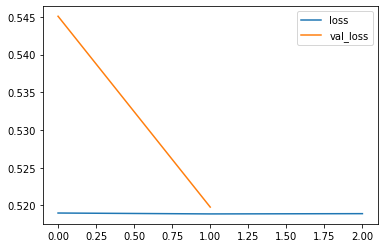


Epoch 00003: saving model to gs://alekseyv-scalableai-dev-criteo-model-bucket/models_jupyter/model_full_adam_raw_gcs_1/checkpoints/epochs:003-accuracy:0.744.hdf5


KeyboardInterrupt: 

In [9]:
def read_raw_kaggle_gcs_one_file():
    gcs_filename = 'gs://alekseyv-scalableai-dev-public-bucket/criteo_kaggle_decompressed/train.txt'
    record_defaults = list(tf.int32 if field.name == 'label' else tf.constant(0, dtype=tf.int32) if field.name.startswith('int') else tf.constant('', dtype=tf.string) for field in CSV_SCHEMA)
    dataset = tf.data.experimental.CsvDataset(gcs_filename, record_defaults, field_delim='\t', header=False)
    
    def transofrom_row_gcs(row_tuple, mean_dict, std_dict, corpus):
        row_dict = dict(zip(list(field.name for field in CSV_SCHEMA), list(row_tuple)))
        return transform_row(row_dict, mean_dict, std_dict, corpus)        

    corpus = get_corpus()
    (mean_dict, std_dict) = get_mean_and_std_dicts()
    transofrom_row_gcs_function = lambda *row_tuple: transofrom_row_gcs(row_tuple, mean_dict, std_dict, corpus)

    transformed_ds = dataset\
      .batch(BATCH_SIZE) \
      .shuffle(50) \
      .map (transofrom_row_gcs_function) \
      .prefetch(50)
    return transformed_ds


def read_raw_kaggle_gcs(is_training):
    file_names = _get_file_names_with_validation_split(is_training, 0.2)
    num_parallel_calls = max(10, len(file_names))
    file_names_ds = dataset_ops.Dataset.from_tensor_slices(file_names).shuffle(buffer_size=20)
    record_defaults = list(tf.int32 if field.name == 'label' else tf.constant(0, dtype=tf.int32) if field.name.startswith('int') else tf.constant('', dtype=tf.string) for field in CSV_SCHEMA)
    dataset = file_names_ds.interleave(
          lambda file_name: tf.data.experimental.CsvDataset(file_name, record_defaults, field_delim='\t', header=False),
          cycle_length=num_parallel_calls,
          num_parallel_calls=num_parallel_calls)
    
    def transofrom_row_gcs(row_tuple, mean_dict, std_dict, corpus):
        row_dict = dict(zip(list(field.name for field in CSV_SCHEMA), list(row_tuple)))
        return transform_row(row_dict, mean_dict, std_dict, corpus)       

    corpus = get_corpus()
    (mean_dict, std_dict) = get_mean_and_std_dicts()
    transofrom_row_gcs_function = lambda *row_tuple: transofrom_row_gcs(row_tuple, mean_dict, std_dict, corpus)

    transformed_ds = dataset\
    .batch(BATCH_SIZE) \
    .shuffle(50) \
    .map (transofrom_row_gcs_function, num_parallel_calls=num_parallel_calls) \
    .prefetch(50)
    return transformed_ds


DATASET_SOURCE = DATASET_SOURCE_TYPE.gcs
DATASET_SIZE = DATASET_SIZE_TYPE.full
EPOCHS = 5
dataset_size = FULL_TRAIN_DATASET_SIZE
logging.info('training datset size: {}'.format(dataset_size))

model_dir = 'gs://alekseyv-scalableai-dev-criteo-model-bucket/models_jupyter/model_full_adam_raw_gcs_1'
feature_columns = create_feature_columns()
feature_layer = tf.keras.layers.DenseFeatures(feature_columns, name="feature_layer")
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
BatchNormalization = tf.keras.layers.BatchNormalization
#kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2',values=[1e-1, 1e-2, 1e-3]))
model = tf.keras.Sequential(
[
  feature_layer,
  Dropout(0.1),
  Dense(600, activation=tf.nn.relu),
  Dense(600, activation=tf.nn.relu),
  Dense(600, activation=tf.nn.relu),
  Dense(1, activation=tf.nn.sigmoid)
])

logging.info('compiling sequential keras model')
# Compile Keras model
model.compile(
  # cannot use Adagrad with mirroredstartegy https://github.com/tensorflow/tensorflow/issues/19551
  #optimizer=tf.optimizers.Adagrad(learning_rate=0.05),
  #optimizer=tf.optimizers.SGD(learning_rate=0.05),
  #optimizer=tf.optimizers.Adam(learning_rate=0.0005),
  #optimizer=tf.optimizers.Adam(),
  optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.1),
  #optimizer=tfa.optimizers.SGDW(learning_rate=0.01, weight_decay=0.001),
  #optimizer=tf.optimizers.Adagrad(),
  #optimizer=tfa.optimizers.LazyAdam(learning_rate=0.0001),

  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

#log_dir= os.path.join(model_dir, "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
log_dir= os.path.join(model_dir, "logs")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
log_dir=log_dir,
histogram_freq=1,
embeddings_freq=1)

checkpoints_dir= os.path.join(model_dir, "checkpoints")
# crashing https://github.com/tensorflow/tensorflow/issues/27688
if not os.path.exists(checkpoints_dir):
  os.makedirs(checkpoints_dir)

callbacks=[]
train_time_callback = TrainTimeCallback()
batch_summary_callback = BatchAccuracyAndLossSummaryCallback(log_dir, DATASET_SIZE)

checkpoints_file_path = checkpoints_dir + "/epochs:{epoch:03d}-accuracy:{accuracy:.3f}.hdf5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoints_file_path, verbose=1, mode='max')
#callbacks=[tensorboard_callback, checkpoint_callback, batch_summary_callback, train_time_callback]
#callbacks=[tensorboard_callback, checkpoint_callback, train_time_callback]
callbacks=[PlotLossesCallback(), tensorboard_callback, checkpoint_callback, train_time_callback]

verbosity = 2
logging.info('training keras model')
training_ds = read_raw_kaggle_gcs(True)
validation_ds = read_raw_kaggle_gcs(False)
model.fit(
    training_ds,
    epochs=EPOCHS,
    verbose=verbosity,
    validation_data=validation_ds,
    callbacks=callbacks)
#model.fit(training_ds, epochs=EPOCHS, verbose=verbosity, callbacks=callbacks)
logging.info("done training keras model, evaluating model")
loss, accuracy = model.evaluate(validation_ds, verbose=verbosity, steps=get_validation_steps_per_epoch(), callbacks=[])
logging.info("Eval - Loss: {}, Accuracy: {}".format(loss, accuracy))
logging.info(model.summary())
